# Afriat

In [1]:
ood_seed = 8

In [2]:
num_ood = 1  # not functioning

In [3]:
import cpa

[rank: 0] Global seed set to 0


In [4]:
import warnings
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import copy
import torch
from pathlib import Path
import networkx as nx
from sklearn.neighbors import kneighbors_graph
import numpy as np
import scanpy as sc
import pandas as pd
import numpy as np
import scipy.stats
import sklearn
from sklearn.dummy import DummyClassifier

print(f"CUDA used: {torch.cuda.is_available()}")

CUDA used: False

In [5]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
_rcparams_path = "/home/icb/kemal.inecik/work/codes/tardis/training/local/figures/rcparams.pickle"
with open(_rcparams_path, 'rb') as file:
    _rcparams = pickle.load(file)
plt.rcParams.update(_rcparams)

In [6]:
adata_file_path = os.path.join("/home/icb/kemal.inecik/lustre_workspace/tardis_data/processed", "biolord_afriat.h5ad")
assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
adata = ad.read_h5ad(adata_file_path)
adata.obs["time_cat"] = adata.obs["time_cat"].astype(str).astype(float).astype(int).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 19053 × 5000
    obs: 'mouse', 'experiment', 'time_int', 'time_cat', 'zone', 'status_control'

In [7]:
df = adata.obs.groupby(['time_cat', 'zone', 'status_control']).size()
availables = list(df[df>100].index)
availables, len(availables)

([('0', 'Pericentral', 'Control'),
  ('0', 'Periportal', 'Control'),
  ('12', 'Pericentral', 'Infected'),
  ('12', 'Pericentral', 'Uninfected'),
  ('12', 'Periportal', 'Infected'),
  ('12', 'Periportal', 'Uninfected'),
  ('2', 'Pericentral', 'Uninfected'),
  ('2', 'Periportal', 'Infected'),
  ('2', 'Periportal', 'Uninfected'),
  ('24', 'Pericentral', 'Infected'),
  ('24', 'Pericentral', 'Uninfected'),
  ('24', 'Periportal', 'Infected'),
  ('24', 'Periportal', 'Uninfected'),
  ('30', 'Pericentral', 'Infected'),
  ('30', 'Pericentral', 'Uninfected'),
  ('30', 'Periportal', 'Infected'),
  ('30', 'Periportal', 'Uninfected'),
  ('36', 'Pericentral', 'Infected'),
  ('36', 'Pericentral', 'Uninfected'),
  ('36', 'Periportal', 'Infected'),
  ('36', 'Periportal', 'Uninfected')],
 21)

In [8]:
def create_random_mask(shape, ratio_true, seed=None):
    rng = np.random.default_rng(seed)
    random_floats = rng.random(shape)
    mask = random_floats < ratio_true
    return mask

def adata_ood_creator(adata, seed, size):
    rng = np.random.default_rng(seed=seed)
    # random_choices = rng.choice(np.arange(len(availables)), size=size, replace=False)
    # choices = [availables[i] for i in random_choices]
    choices = [availables[ood_seed]]
    for choice in choices:
        print(choice)
    choices_bool = np.vstack([(adata.obs["time_cat"] == choice[0]) & (adata.obs["zone"] == choice[1]) & (adata.obs["status_control"] == choice[2]) for choice in choices]).any(axis=0)
    print(f"\nRemoved datapoint: {choices_bool.sum()}")
    return adata[~choices_bool, :].copy(), choices_bool

_, choices_bool = adata_ood_creator(adata, seed=ood_seed, size=num_ood)
train_split = create_random_mask(len(adata), ratio_true=0.8)
adata.obs["split"] = "validation"
adata.obs["split"][train_split] = "train"
adata.obs["split"][choices_bool] = "ood" 
adata.obs["split"].value_counts()

('2', 'Periportal', 'Uninfected')


Removed datapoint: 1330

train         14274
validation     3449
ood            1330
Name: split, dtype: int64

In [9]:
dir_path = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/models",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}"
)

In [10]:
cpa.CPA.setup_anndata(
    adata,
    # does not allow empty or all same placeholder column for below.
    perturbation_key="time_cat",
    control_group="0",
    batch_key=None,
    is_count_data=True,
    categorical_covariate_keys=['zone', 'status_control'],
)

  0%|          | 0/19053 [00:00<?, ?it/s]

 56%|█████▋    | 10758/19053 [00:00<00:00, 107576.26it/s]

100%|██████████| 19053/19053 [00:00<00:00, 107157.61it/s]

  0%|          | 0/19053 [00:00<?, ?it/s]

100%|██████████| 19053/19053 [00:00<00:00, 1143655.53it/s]

INFO    

 Generating sequential column names                                                                        


INFO    

 Generating sequential column names                                                                        


In [11]:
model = cpa.CPA(
    adata=adata, 
    n_latent=24,
    split_key='split',
    train_split='train',
    valid_split='validation',
    test_split='ood'
)

[rank: 0] Global seed set to 0


In [12]:
model.train(max_epochs=400)

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00, 432.91it/s]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores


IPU available: False, using: 0 IPUs


HPU available: False, using: 0 HPUs


Training:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

Epoch 1/400:   0%|          | 1/400 [00:09<1:00:17,  9.07s/it]

Epoch 1/400:   0%|          | 1/400 [00:09<1:00:17,  9.07s/it, v_num=1, recon=3.95e+3, r2_mean=0.198, adv_loss=3.27, acc_pert=0.265, acc_zone=0.738, acc_status_control=0.475]

Epoch 2/400:   0%|          | 1/400 [00:09<1:00:17,  9.07s/it, v_num=1, recon=3.95e+3, r2_mean=0.198, adv_loss=3.27, acc_pert=0.265, acc_zone=0.738, acc_status_control=0.475]

Epoch 2/400:   0%|          | 2/400 [00:17<58:42,  8.85s/it, v_num=1, recon=3.95e+3, r2_mean=0.198, adv_loss=3.27, acc_pert=0.265, acc_zone=0.738, acc_status_control=0.475]  

Epoch 2/400:   0%|          | 2/400 [00:17<58:42,  8.85s/it, v_num=1, recon=3.23e+3, r2_mean=0.606, adv_loss=2.85, acc_pert=0.359, acc_zone=0.838, acc_status_control=0.6]  

Epoch 3/400:   0%|          | 2/400 [00:17<58:42,  8.85s/it, v_num=1, recon=3.23e+3, r2_mean=0.606, adv_loss=2.85, acc_pert=0.359, acc_zone=0.838, acc_status_control=0.6]

Epoch 3/400:   1%|          | 3/400 [00:26<58:00,  8.77s/it, v_num=1, recon=3.23e+3, r2_mean=0.606, adv_loss=2.85, acc_pert=0.359, acc_zone=0.838, acc_status_control=0.6]

Epoch 3/400:   1%|          | 3/400 [00:26<58:00,  8.77s/it, v_num=1, recon=3.17e+3, r2_mean=0.709, adv_loss=2.82, acc_pert=0.393, acc_zone=0.837, acc_status_control=0.592]

Epoch 4/400:   1%|          | 3/400 [00:26<58:00,  8.77s/it, v_num=1, recon=3.17e+3, r2_mean=0.709, adv_loss=2.82, acc_pert=0.393, acc_zone=0.837, acc_status_control=0.592]

Epoch 4/400:   1%|          | 4/400 [00:35<57:42,  8.74s/it, v_num=1, recon=3.17e+3, r2_mean=0.709, adv_loss=2.82, acc_pert=0.393, acc_zone=0.837, acc_status_control=0.592]

Epoch 4/400:   1%|          | 4/400 [00:35<57:42,  8.74s/it, v_num=1, recon=3.15e+3, r2_mean=0.747, adv_loss=2.81, acc_pert=0.399, acc_zone=0.828, acc_status_control=0.585]

Epoch 5/400:   1%|          | 4/400 [00:35<57:42,  8.74s/it, v_num=1, recon=3.15e+3, r2_mean=0.747, adv_loss=2.81, acc_pert=0.399, acc_zone=0.828, acc_status_control=0.585]

Epoch 5/400:   1%|▏         | 5/400 [00:43<57:35,  8.75s/it, v_num=1, recon=3.15e+3, r2_mean=0.747, adv_loss=2.81, acc_pert=0.399, acc_zone=0.828, acc_status_control=0.585]

Epoch 5/400:   1%|▏         | 5/400 [00:43<57:35,  8.75s/it, v_num=1, recon=3.14e+3, r2_mean=0.77, adv_loss=2.69, acc_pert=0.435, acc_zone=0.829, acc_status_control=0.592] 

Epoch 6/400:   1%|▏         | 5/400 [00:43<57:35,  8.75s/it, v_num=1, recon=3.14e+3, r2_mean=0.77, adv_loss=2.69, acc_pert=0.435, acc_zone=0.829, acc_status_control=0.592]

Epoch 6/400:   2%|▏         | 6/400 [00:52<57:28,  8.75s/it, v_num=1, recon=3.14e+3, r2_mean=0.77, adv_loss=2.69, acc_pert=0.435, acc_zone=0.829, acc_status_control=0.592]

Epoch 6/400:   2%|▏         | 6/400 [00:52<57:28,  8.75s/it, v_num=1, recon=3.13e+3, r2_mean=0.784, adv_loss=2.63, acc_pert=0.447, acc_zone=0.838, acc_status_control=0.588]

Epoch 7/400:   2%|▏         | 6/400 [00:52<57:28,  8.75s/it, v_num=1, recon=3.13e+3, r2_mean=0.784, adv_loss=2.63, acc_pert=0.447, acc_zone=0.838, acc_status_control=0.588]

Epoch 7/400:   2%|▏         | 7/400 [01:01<57:19,  8.75s/it, v_num=1, recon=3.13e+3, r2_mean=0.784, adv_loss=2.63, acc_pert=0.447, acc_zone=0.838, acc_status_control=0.588]

Epoch 7/400:   2%|▏         | 7/400 [01:01<57:19,  8.75s/it, v_num=1, recon=3.12e+3, r2_mean=0.795, adv_loss=2.58, acc_pert=0.464, acc_zone=0.842, acc_status_control=0.586]

Epoch 8/400:   2%|▏         | 7/400 [01:01<57:19,  8.75s/it, v_num=1, recon=3.12e+3, r2_mean=0.795, adv_loss=2.58, acc_pert=0.464, acc_zone=0.842, acc_status_control=0.586]

Epoch 8/400:   2%|▏         | 8/400 [01:10<57:18,  8.77s/it, v_num=1, recon=3.12e+3, r2_mean=0.795, adv_loss=2.58, acc_pert=0.464, acc_zone=0.842, acc_status_control=0.586]

Epoch 8/400:   2%|▏         | 8/400 [01:10<57:18,  8.77s/it, v_num=1, recon=3.12e+3, r2_mean=0.8, adv_loss=2.48, acc_pert=0.528, acc_zone=0.843, acc_status_control=0.589]  

Epoch 9/400:   2%|▏         | 8/400 [01:10<57:18,  8.77s/it, v_num=1, recon=3.12e+3, r2_mean=0.8, adv_loss=2.48, acc_pert=0.528, acc_zone=0.843, acc_status_control=0.589]

Epoch 9/400:   2%|▏         | 9/400 [01:19<57:13,  8.78s/it, v_num=1, recon=3.12e+3, r2_mean=0.8, adv_loss=2.48, acc_pert=0.528, acc_zone=0.843, acc_status_control=0.589]

Epoch 9/400:   2%|▏         | 9/400 [01:19<57:13,  8.78s/it, v_num=1, recon=3.11e+3, r2_mean=0.803, adv_loss=2.37, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.595]

Epoch 10/400:   2%|▏         | 9/400 [01:19<57:13,  8.78s/it, v_num=1, recon=3.11e+3, r2_mean=0.803, adv_loss=2.37, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.595]


disnt_basal = 1.2376850441667089

disnt_after = 1.9066978827897614

val_r2_mean = 0.8070954077456235

val_r2_var = 0.17474246097908233


Epoch 00009: cpa_metric reached. Module best state updated.


Epoch 10/400:   2%|▎         | 10/400 [01:32<1:05:37, 10.09s/it, v_num=1, recon=3.11e+3, r2_mean=0.803, adv_loss=2.37, acc_pert=0.579, acc_zone=0.843, acc_status_control=0.595]

Epoch 10/400:   2%|▎         | 10/400 [01:32<1:05:37, 10.09s/it, v_num=1, recon=3.1e+3, r2_mean=0.807, adv_loss=2.29, acc_pert=0.616, acc_zone=0.843, acc_status_control=0.597, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 11/400:   2%|▎         | 10/400 [01:32<1:05:37, 10.09s/it, v_num=1, recon=3.1e+3, r2_mean=0.807, adv_loss=2.29, acc_pert=0.616, acc_zone=0.843, acc_status_control=0.597, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:40<1:02:36,  9.66s/it, v_num=1, recon=3.1e+3, r2_mean=0.807, adv_loss=2.29, acc_pert=0.616, acc_zone=0.843, acc_status_control=0.597, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 11/400:   3%|▎         | 11/400 [01:40<1:02:36,  9.66s/it, v_num=1, recon=3.1e+3, r2_mean=0.812, adv_loss=2.19, acc_pert=0.649, acc_zone=0.849, acc_status_control=0.598, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 12/400:   3%|▎         | 11/400 [01:40<1:02:36,  9.66s/it, v_num=1, recon=3.1e+3, r2_mean=0.812, adv_loss=2.19, acc_pert=0.649, acc_zone=0.849, acc_status_control=0.598, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:49<1:00:43,  9.39s/it, v_num=1, recon=3.1e+3, r2_mean=0.812, adv_loss=2.19, acc_pert=0.649, acc_zone=0.849, acc_status_control=0.598, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 12/400:   3%|▎         | 12/400 [01:49<1:00:43,  9.39s/it, v_num=1, recon=3.09e+3, r2_mean=0.813, adv_loss=2.16, acc_pert=0.663, acc_zone=0.852, acc_status_control=0.602, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 13/400:   3%|▎         | 12/400 [01:49<1:00:43,  9.39s/it, v_num=1, recon=3.09e+3, r2_mean=0.813, adv_loss=2.16, acc_pert=0.663, acc_zone=0.852, acc_status_control=0.602, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 13/400:   3%|▎         | 13/400 [01:58<59:17,  9.19s/it, v_num=1, recon=3.09e+3, r2_mean=0.813, adv_loss=2.16, acc_pert=0.663, acc_zone=0.852, acc_status_control=0.602, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]  

Epoch 13/400:   3%|▎         | 13/400 [01:58<59:17,  9.19s/it, v_num=1, recon=3.08e+3, r2_mean=0.816, adv_loss=2.17, acc_pert=0.659, acc_zone=0.85, acc_status_control=0.602, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan] 

Epoch 14/400:   3%|▎         | 13/400 [01:58<59:17,  9.19s/it, v_num=1, recon=3.08e+3, r2_mean=0.816, adv_loss=2.17, acc_pert=0.659, acc_zone=0.85, acc_status_control=0.602, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:06<58:05,  9.03s/it, v_num=1, recon=3.08e+3, r2_mean=0.816, adv_loss=2.17, acc_pert=0.659, acc_zone=0.85, acc_status_control=0.602, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 14/400:   4%|▎         | 14/400 [02:06<58:05,  9.03s/it, v_num=1, recon=3.08e+3, r2_mean=0.819, adv_loss=2.13, acc_pert=0.668, acc_zone=0.849, acc_status_control=0.608, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 15/400:   4%|▎         | 14/400 [02:06<58:05,  9.03s/it, v_num=1, recon=3.08e+3, r2_mean=0.819, adv_loss=2.13, acc_pert=0.668, acc_zone=0.849, acc_status_control=0.608, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:15<57:25,  8.95s/it, v_num=1, recon=3.08e+3, r2_mean=0.819, adv_loss=2.13, acc_pert=0.668, acc_zone=0.849, acc_status_control=0.608, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 15/400:   4%|▍         | 15/400 [02:15<57:25,  8.95s/it, v_num=1, recon=3.08e+3, r2_mean=0.819, adv_loss=2.1, acc_pert=0.675, acc_zone=0.855, acc_status_control=0.609, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan] 

Epoch 16/400:   4%|▍         | 15/400 [02:15<57:25,  8.95s/it, v_num=1, recon=3.08e+3, r2_mean=0.819, adv_loss=2.1, acc_pert=0.675, acc_zone=0.855, acc_status_control=0.609, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:24<56:56,  8.90s/it, v_num=1, recon=3.08e+3, r2_mean=0.819, adv_loss=2.1, acc_pert=0.675, acc_zone=0.855, acc_status_control=0.609, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 16/400:   4%|▍         | 16/400 [02:24<56:56,  8.90s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=2.06, acc_pert=0.683, acc_zone=0.849, acc_status_control=0.614, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 17/400:   4%|▍         | 16/400 [02:24<56:56,  8.90s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=2.06, acc_pert=0.683, acc_zone=0.849, acc_status_control=0.614, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:33<56:31,  8.86s/it, v_num=1, recon=3.07e+3, r2_mean=0.821, adv_loss=2.06, acc_pert=0.683, acc_zone=0.849, acc_status_control=0.614, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 17/400:   4%|▍         | 17/400 [02:33<56:31,  8.86s/it, v_num=1, recon=3.07e+3, r2_mean=0.82, adv_loss=2.02, acc_pert=0.693, acc_zone=0.849, acc_status_control=0.623, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan] 

Epoch 18/400:   4%|▍         | 17/400 [02:33<56:31,  8.86s/it, v_num=1, recon=3.07e+3, r2_mean=0.82, adv_loss=2.02, acc_pert=0.693, acc_zone=0.849, acc_status_control=0.623, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:41<56:07,  8.82s/it, v_num=1, recon=3.07e+3, r2_mean=0.82, adv_loss=2.02, acc_pert=0.693, acc_zone=0.849, acc_status_control=0.623, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 18/400:   4%|▍         | 18/400 [02:41<56:07,  8.82s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=2.01, acc_pert=0.693, acc_zone=0.851, acc_status_control=0.623, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 19/400:   4%|▍         | 18/400 [02:41<56:07,  8.82s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=2.01, acc_pert=0.693, acc_zone=0.851, acc_status_control=0.623, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:50<55:59,  8.82s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=2.01, acc_pert=0.693, acc_zone=0.851, acc_status_control=0.623, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 19/400:   5%|▍         | 19/400 [02:50<55:59,  8.82s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=2.02, acc_pert=0.687, acc_zone=0.848, acc_status_control=0.625, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 20/400:   5%|▍         | 19/400 [02:50<55:59,  8.82s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=2.02, acc_pert=0.687, acc_zone=0.848, acc_status_control=0.625, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]


disnt_basal = 1.2681516279225453

disnt_after = 1.9017092414479455

val_r2_mean = 0.8190279370252745

val_r2_var = 0.21738919236865611

Epoch 20/400:   5%|▌         | 20/400 [03:03<1:03:51, 10.08s/it, v_num=1, recon=3.06e+3, r2_mean=0.823, adv_loss=2.02, acc_pert=0.687, acc_zone=0.848, acc_status_control=0.625, val_recon=3.14e+3, disnt_basal=1.24, disnt_after=1.91, val_r2_mean=0.807, val_KL=nan]

Epoch 20/400:   5%|▌         | 20/400 [03:03<1:03:51, 10.08s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.02, acc_pert=0.683, acc_zone=0.852, acc_status_control=0.625, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan] 

Epoch 21/400:   5%|▌         | 20/400 [03:03<1:03:51, 10.08s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.02, acc_pert=0.683, acc_zone=0.852, acc_status_control=0.625, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:12<1:01:20,  9.71s/it, v_num=1, recon=3.06e+3, r2_mean=0.826, adv_loss=2.02, acc_pert=0.683, acc_zone=0.852, acc_status_control=0.625, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 21/400:   5%|▌         | 21/400 [03:12<1:01:20,  9.71s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2.03, acc_pert=0.683, acc_zone=0.849, acc_status_control=0.627, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 22/400:   5%|▌         | 21/400 [03:12<1:01:20,  9.71s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2.03, acc_pert=0.683, acc_zone=0.849, acc_status_control=0.627, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 22/400:   6%|▌         | 22/400 [03:21<59:27,  9.44s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2.03, acc_pert=0.683, acc_zone=0.849, acc_status_control=0.627, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]  

Epoch 22/400:   6%|▌         | 22/400 [03:21<59:27,  9.44s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2.04, acc_pert=0.682, acc_zone=0.85, acc_status_control=0.628, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan] 

Epoch 23/400:   6%|▌         | 22/400 [03:21<59:27,  9.44s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2.04, acc_pert=0.682, acc_zone=0.85, acc_status_control=0.628, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:30<58:03,  9.24s/it, v_num=1, recon=3.05e+3, r2_mean=0.825, adv_loss=2.04, acc_pert=0.682, acc_zone=0.85, acc_status_control=0.628, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 23/400:   6%|▌         | 23/400 [03:30<58:03,  9.24s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=2.02, acc_pert=0.682, acc_zone=0.848, acc_status_control=0.633, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 24/400:   6%|▌         | 23/400 [03:30<58:03,  9.24s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=2.02, acc_pert=0.682, acc_zone=0.848, acc_status_control=0.633, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:38<56:55,  9.09s/it, v_num=1, recon=3.05e+3, r2_mean=0.826, adv_loss=2.02, acc_pert=0.682, acc_zone=0.848, acc_status_control=0.633, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 24/400:   6%|▌         | 24/400 [03:38<56:55,  9.09s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.03, acc_pert=0.68, acc_zone=0.851, acc_status_control=0.634, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan] 

Epoch 25/400:   6%|▌         | 24/400 [03:38<56:55,  9.09s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.03, acc_pert=0.68, acc_zone=0.851, acc_status_control=0.634, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:47<56:13,  9.00s/it, v_num=1, recon=3.04e+3, r2_mean=0.827, adv_loss=2.03, acc_pert=0.68, acc_zone=0.851, acc_status_control=0.634, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 25/400:   6%|▋         | 25/400 [03:47<56:13,  9.00s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=2.03, acc_pert=0.679, acc_zone=0.848, acc_status_control=0.634, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 26/400:   6%|▋         | 25/400 [03:47<56:13,  9.00s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=2.03, acc_pert=0.679, acc_zone=0.848, acc_status_control=0.634, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:56<55:39,  8.93s/it, v_num=1, recon=3.04e+3, r2_mean=0.826, adv_loss=2.03, acc_pert=0.679, acc_zone=0.848, acc_status_control=0.634, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 26/400:   6%|▋         | 26/400 [03:56<55:39,  8.93s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.68, acc_zone=0.848, acc_status_control=0.636, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan] 

Epoch 27/400:   6%|▋         | 26/400 [03:56<55:39,  8.93s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.68, acc_zone=0.848, acc_status_control=0.636, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:05<55:15,  8.89s/it, v_num=1, recon=3.04e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.68, acc_zone=0.848, acc_status_control=0.636, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 27/400:   7%|▋         | 27/400 [04:05<55:15,  8.89s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.68, acc_zone=0.849, acc_status_control=0.632, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 28/400:   7%|▋         | 27/400 [04:05<55:15,  8.89s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.68, acc_zone=0.849, acc_status_control=0.632, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:14<54:50,  8.85s/it, v_num=1, recon=3.03e+3, r2_mean=0.828, adv_loss=2.04, acc_pert=0.68, acc_zone=0.849, acc_status_control=0.632, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 28/400:   7%|▋         | 28/400 [04:14<54:50,  8.85s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=2.04, acc_pert=0.682, acc_zone=0.848, acc_status_control=0.631, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 29/400:   7%|▋         | 28/400 [04:14<54:50,  8.85s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=2.04, acc_pert=0.682, acc_zone=0.848, acc_status_control=0.631, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:22<54:29,  8.81s/it, v_num=1, recon=3.03e+3, r2_mean=0.826, adv_loss=2.04, acc_pert=0.682, acc_zone=0.848, acc_status_control=0.631, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 29/400:   7%|▋         | 29/400 [04:22<54:29,  8.81s/it, v_num=1, recon=3.03e+3, r2_mean=0.825, adv_loss=2.04, acc_pert=0.677, acc_zone=0.849, acc_status_control=0.632, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 30/400:   7%|▋         | 29/400 [04:22<54:29,  8.81s/it, v_num=1, recon=3.03e+3, r2_mean=0.825, adv_loss=2.04, acc_pert=0.677, acc_zone=0.849, acc_status_control=0.632, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]


disnt_basal = 1.2628915045863338

disnt_after = 1.8979396057963982

val_r2_mean = 0.823085524850215

val_r2_var = 0.2422794294100394

Epoch 30/400:   8%|▊         | 30/400 [04:35<1:02:30, 10.14s/it, v_num=1, recon=3.03e+3, r2_mean=0.825, adv_loss=2.04, acc_pert=0.677, acc_zone=0.849, acc_status_control=0.632, val_recon=3.09e+3, disnt_basal=1.27, disnt_after=1.9, val_r2_mean=0.819, val_KL=nan]

Epoch 30/400:   8%|▊         | 30/400 [04:35<1:02:30, 10.14s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.03, acc_pert=0.675, acc_zone=0.847, acc_status_control=0.634, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 31/400:   8%|▊         | 30/400 [04:35<1:02:30, 10.14s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.03, acc_pert=0.675, acc_zone=0.847, acc_status_control=0.634, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 31/400:   8%|▊         | 31/400 [04:44<59:58,  9.75s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.03, acc_pert=0.675, acc_zone=0.847, acc_status_control=0.634, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]  

Epoch 31/400:   8%|▊         | 31/400 [04:44<59:58,  9.75s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.677, acc_zone=0.847, acc_status_control=0.636, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 32/400:   8%|▊         | 31/400 [04:44<59:58,  9.75s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.677, acc_zone=0.847, acc_status_control=0.636, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:53<58:00,  9.46s/it, v_num=1, recon=3.02e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.677, acc_zone=0.847, acc_status_control=0.636, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 32/400:   8%|▊         | 32/400 [04:53<58:00,  9.46s/it, v_num=1, recon=3.02e+3, r2_mean=0.827, adv_loss=2.05, acc_pert=0.671, acc_zone=0.844, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 33/400:   8%|▊         | 32/400 [04:53<58:00,  9.46s/it, v_num=1, recon=3.02e+3, r2_mean=0.827, adv_loss=2.05, acc_pert=0.671, acc_zone=0.844, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:02<56:47,  9.28s/it, v_num=1, recon=3.02e+3, r2_mean=0.827, adv_loss=2.05, acc_pert=0.671, acc_zone=0.844, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 33/400:   8%|▊         | 33/400 [05:02<56:47,  9.28s/it, v_num=1, recon=3.02e+3, r2_mean=0.827, adv_loss=2.04, acc_pert=0.684, acc_zone=0.845, acc_status_control=0.636, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 34/400:   8%|▊         | 33/400 [05:02<56:47,  9.28s/it, v_num=1, recon=3.02e+3, r2_mean=0.827, adv_loss=2.04, acc_pert=0.684, acc_zone=0.845, acc_status_control=0.636, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:11<55:32,  9.11s/it, v_num=1, recon=3.02e+3, r2_mean=0.827, adv_loss=2.04, acc_pert=0.684, acc_zone=0.845, acc_status_control=0.636, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 34/400:   8%|▊         | 34/400 [05:11<55:32,  9.11s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=2.03, acc_pert=0.682, acc_zone=0.847, acc_status_control=0.631, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 35/400:   8%|▊         | 34/400 [05:11<55:32,  9.11s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=2.03, acc_pert=0.682, acc_zone=0.847, acc_status_control=0.631, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:19<54:34,  8.97s/it, v_num=1, recon=3.01e+3, r2_mean=0.828, adv_loss=2.03, acc_pert=0.682, acc_zone=0.847, acc_status_control=0.631, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 35/400:   9%|▉         | 35/400 [05:19<54:34,  8.97s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.679, acc_zone=0.846, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 36/400:   9%|▉         | 35/400 [05:19<54:34,  8.97s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.679, acc_zone=0.846, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:28<53:59,  8.90s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.679, acc_zone=0.846, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 36/400:   9%|▉         | 36/400 [05:28<53:59,  8.90s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.685, acc_zone=0.845, acc_status_control=0.634, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 37/400:   9%|▉         | 36/400 [05:28<53:59,  8.90s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.685, acc_zone=0.845, acc_status_control=0.634, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:37<53:31,  8.85s/it, v_num=1, recon=3.01e+3, r2_mean=0.829, adv_loss=2.04, acc_pert=0.685, acc_zone=0.845, acc_status_control=0.634, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 37/400:   9%|▉         | 37/400 [05:37<53:31,  8.85s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.687, acc_zone=0.847, acc_status_control=0.635, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]   

Epoch 38/400:   9%|▉         | 37/400 [05:37<53:31,  8.85s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.687, acc_zone=0.847, acc_status_control=0.635, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:46<53:14,  8.83s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.03, acc_pert=0.687, acc_zone=0.847, acc_status_control=0.635, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 38/400:  10%|▉         | 38/400 [05:46<53:14,  8.83s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=2.02, acc_pert=0.681, acc_zone=0.846, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 39/400:  10%|▉         | 38/400 [05:46<53:14,  8.83s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=2.02, acc_pert=0.681, acc_zone=0.846, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:54<52:49,  8.78s/it, v_num=1, recon=3e+3, r2_mean=0.829, adv_loss=2.02, acc_pert=0.681, acc_zone=0.846, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 39/400:  10%|▉         | 39/400 [05:54<52:49,  8.78s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.672, acc_zone=0.843, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 40/400:  10%|▉         | 39/400 [05:54<52:49,  8.78s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.672, acc_zone=0.843, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.250476719952259

disnt_after = 1.890657047108164

val_r2_mean = 0.8270647567458901

val_r2_var = 0.2595173268332926


Epoch 00039: cpa_metric reached. Module best state updated.


Epoch 40/400:  10%|█         | 40/400 [06:07<1:00:15, 10.04s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.672, acc_zone=0.843, acc_status_control=0.633, val_recon=3.06e+3, disnt_basal=1.26, disnt_after=1.9, val_r2_mean=0.823, val_KL=nan]

Epoch 40/400:  10%|█         | 40/400 [06:07<1:00:15, 10.04s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.676, acc_zone=0.845, acc_status_control=0.632, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 41/400:  10%|█         | 40/400 [06:07<1:00:15, 10.04s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.676, acc_zone=0.845, acc_status_control=0.632, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 41/400:  10%|█         | 41/400 [06:16<57:35,  9.62s/it, v_num=1, recon=3e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.676, acc_zone=0.845, acc_status_control=0.632, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]  

Epoch 41/400:  10%|█         | 41/400 [06:16<57:35,  9.62s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.675, acc_zone=0.845, acc_status_control=0.639, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 42/400:  10%|█         | 41/400 [06:16<57:35,  9.62s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.675, acc_zone=0.845, acc_status_control=0.639, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:25<55:53,  9.37s/it, v_num=1, recon=3e+3, r2_mean=0.833, adv_loss=2.05, acc_pert=0.675, acc_zone=0.845, acc_status_control=0.639, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 42/400:  10%|█         | 42/400 [06:25<55:53,  9.37s/it, v_num=1, recon=2.99e+3, r2_mean=0.83, adv_loss=2.06, acc_pert=0.677, acc_zone=0.842, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 43/400:  10%|█         | 42/400 [06:25<55:53,  9.37s/it, v_num=1, recon=2.99e+3, r2_mean=0.83, adv_loss=2.06, acc_pert=0.677, acc_zone=0.842, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:33<54:33,  9.17s/it, v_num=1, recon=2.99e+3, r2_mean=0.83, adv_loss=2.06, acc_pert=0.677, acc_zone=0.842, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 43/400:  11%|█         | 43/400 [06:33<54:33,  9.17s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.07, acc_pert=0.669, acc_zone=0.842, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 44/400:  11%|█         | 43/400 [06:33<54:33,  9.17s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.07, acc_pert=0.669, acc_zone=0.842, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:42<53:33,  9.03s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.07, acc_pert=0.669, acc_zone=0.842, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 44/400:  11%|█         | 44/400 [06:42<53:33,  9.03s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.673, acc_zone=0.843, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 45/400:  11%|█         | 44/400 [06:42<53:33,  9.03s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.673, acc_zone=0.843, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:51<52:54,  8.94s/it, v_num=1, recon=2.99e+3, r2_mean=0.831, adv_loss=2.06, acc_pert=0.673, acc_zone=0.843, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 45/400:  11%|█▏        | 45/400 [06:51<52:54,  8.94s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.07, acc_pert=0.668, acc_zone=0.84, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan] 

Epoch 46/400:  11%|█▏        | 45/400 [06:51<52:54,  8.94s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.07, acc_pert=0.668, acc_zone=0.84, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:00<52:26,  8.89s/it, v_num=1, recon=2.99e+3, r2_mean=0.832, adv_loss=2.07, acc_pert=0.668, acc_zone=0.84, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 46/400:  12%|█▏        | 46/400 [07:00<52:26,  8.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.07, acc_pert=0.674, acc_zone=0.842, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 47/400:  12%|█▏        | 46/400 [07:00<52:26,  8.89s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.07, acc_pert=0.674, acc_zone=0.842, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:08<52:00,  8.84s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.07, acc_pert=0.674, acc_zone=0.842, acc_status_control=0.634, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 47/400:  12%|█▏        | 47/400 [07:08<52:00,  8.84s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.08, acc_pert=0.668, acc_zone=0.846, acc_status_control=0.637, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 48/400:  12%|█▏        | 47/400 [07:08<52:00,  8.84s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.08, acc_pert=0.668, acc_zone=0.846, acc_status_control=0.637, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:17<51:36,  8.80s/it, v_num=1, recon=2.98e+3, r2_mean=0.835, adv_loss=2.08, acc_pert=0.668, acc_zone=0.846, acc_status_control=0.637, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 48/400:  12%|█▏        | 48/400 [07:17<51:36,  8.80s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.656, acc_zone=0.837, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 49/400:  12%|█▏        | 48/400 [07:17<51:36,  8.80s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.656, acc_zone=0.837, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:26<51:10,  8.75s/it, v_num=1, recon=2.98e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.656, acc_zone=0.837, acc_status_control=0.636, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 49/400:  12%|█▏        | 49/400 [07:26<51:10,  8.75s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.09, acc_pert=0.665, acc_zone=0.838, acc_status_control=0.632, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 50/400:  12%|█▏        | 49/400 [07:26<51:10,  8.75s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.09, acc_pert=0.665, acc_zone=0.838, acc_status_control=0.632, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2470683244066805

disnt_after = 1.8986054988342274

val_r2_mean = 0.8294130993289868

val_r2_var = 0.28099066052158905


Epoch 00049: cpa_metric reached. Module best state updated.


Epoch 50/400:  12%|█▎        | 50/400 [07:39<58:36, 10.05s/it, v_num=1, recon=2.98e+3, r2_mean=0.831, adv_loss=2.09, acc_pert=0.665, acc_zone=0.838, acc_status_control=0.632, val_recon=3.04e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.827, val_KL=nan]

Epoch 50/400:  12%|█▎        | 50/400 [07:39<58:36, 10.05s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.663, acc_zone=0.84, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]  

Epoch 51/400:  12%|█▎        | 50/400 [07:39<58:36, 10.05s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.663, acc_zone=0.84, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:47<56:04,  9.64s/it, v_num=1, recon=2.97e+3, r2_mean=0.834, adv_loss=2.09, acc_pert=0.663, acc_zone=0.84, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 51/400:  13%|█▎        | 51/400 [07:47<56:04,  9.64s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.11, acc_pert=0.657, acc_zone=0.839, acc_status_control=0.631, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 52/400:  13%|█▎        | 51/400 [07:47<56:04,  9.64s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.11, acc_pert=0.657, acc_zone=0.839, acc_status_control=0.631, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [07:56<54:23,  9.38s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.11, acc_pert=0.657, acc_zone=0.839, acc_status_control=0.631, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 52/400:  13%|█▎        | 52/400 [07:56<54:23,  9.38s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.11, acc_pert=0.661, acc_zone=0.836, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 53/400:  13%|█▎        | 52/400 [07:56<54:23,  9.38s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.11, acc_pert=0.661, acc_zone=0.836, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:05<53:07,  9.19s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.11, acc_pert=0.661, acc_zone=0.836, acc_status_control=0.635, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 53/400:  13%|█▎        | 53/400 [08:05<53:07,  9.19s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.657, acc_zone=0.832, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 54/400:  13%|█▎        | 53/400 [08:05<53:07,  9.19s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.657, acc_zone=0.832, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:14<52:06,  9.04s/it, v_num=1, recon=2.97e+3, r2_mean=0.832, adv_loss=2.11, acc_pert=0.657, acc_zone=0.832, acc_status_control=0.633, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 54/400:  14%|█▎        | 54/400 [08:14<52:06,  9.04s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.652, acc_zone=0.84, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]  

Epoch 55/400:  14%|█▎        | 54/400 [08:14<52:06,  9.04s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.652, acc_zone=0.84, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:22<51:31,  8.96s/it, v_num=1, recon=2.97e+3, r2_mean=0.835, adv_loss=2.1, acc_pert=0.652, acc_zone=0.84, acc_status_control=0.637, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 55/400:  14%|█▍        | 55/400 [08:22<51:31,  8.96s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.1, acc_pert=0.658, acc_zone=0.837, acc_status_control=0.632, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 56/400:  14%|█▍        | 55/400 [08:22<51:31,  8.96s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.1, acc_pert=0.658, acc_zone=0.837, acc_status_control=0.632, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:31<51:29,  8.98s/it, v_num=1, recon=2.97e+3, r2_mean=0.833, adv_loss=2.1, acc_pert=0.658, acc_zone=0.837, acc_status_control=0.632, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 56/400:  14%|█▍        | 56/400 [08:31<51:29,  8.98s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.653, acc_zone=0.835, acc_status_control=0.629, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 57/400:  14%|█▍        | 56/400 [08:31<51:29,  8.98s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.653, acc_zone=0.835, acc_status_control=0.629, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:40<51:01,  8.93s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.11, acc_pert=0.653, acc_zone=0.835, acc_status_control=0.629, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 57/400:  14%|█▍        | 57/400 [08:40<51:01,  8.93s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.12, acc_pert=0.649, acc_zone=0.838, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 58/400:  14%|█▍        | 57/400 [08:40<51:01,  8.93s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.12, acc_pert=0.649, acc_zone=0.838, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:49<50:38,  8.88s/it, v_num=1, recon=2.96e+3, r2_mean=0.832, adv_loss=2.12, acc_pert=0.649, acc_zone=0.838, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 58/400:  14%|█▍        | 58/400 [08:49<50:38,  8.88s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.654, acc_zone=0.837, acc_status_control=0.632, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 59/400:  14%|█▍        | 58/400 [08:49<50:38,  8.88s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.654, acc_zone=0.837, acc_status_control=0.632, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [08:58<50:12,  8.83s/it, v_num=1, recon=2.96e+3, r2_mean=0.836, adv_loss=2.11, acc_pert=0.654, acc_zone=0.837, acc_status_control=0.632, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 59/400:  15%|█▍        | 59/400 [08:58<50:12,  8.83s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.647, acc_zone=0.837, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 60/400:  15%|█▍        | 59/400 [08:58<50:12,  8.83s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.647, acc_zone=0.837, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.249012099562105

disnt_after = 1.8886407717763953

val_r2_mean = 0.8261187989168479

val_r2_var = 0.27777034103354764

Epoch 60/400:  15%|█▌        | 60/400 [09:11<56:59, 10.06s/it, v_num=1, recon=2.96e+3, r2_mean=0.833, adv_loss=2.12, acc_pert=0.647, acc_zone=0.837, acc_status_control=0.634, val_recon=3.02e+3, disnt_basal=1.25, disnt_after=1.9, val_r2_mean=0.829, val_KL=nan]

Epoch 60/400:  15%|█▌        | 60/400 [09:11<56:59, 10.06s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.645, acc_zone=0.838, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 61/400:  15%|█▌        | 60/400 [09:11<56:59, 10.06s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.645, acc_zone=0.838, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:19<54:32,  9.65s/it, v_num=1, recon=2.96e+3, r2_mean=0.834, adv_loss=2.12, acc_pert=0.645, acc_zone=0.838, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 61/400:  15%|█▌        | 61/400 [09:19<54:32,  9.65s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.642, acc_zone=0.836, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 62/400:  15%|█▌        | 61/400 [09:19<54:32,  9.65s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.642, acc_zone=0.836, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [09:28<52:51,  9.38s/it, v_num=1, recon=2.96e+3, r2_mean=0.837, adv_loss=2.12, acc_pert=0.642, acc_zone=0.836, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 62/400:  16%|█▌        | 62/400 [09:28<52:51,  9.38s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.643, acc_zone=0.838, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 63/400:  16%|█▌        | 62/400 [09:28<52:51,  9.38s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.643, acc_zone=0.838, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:37<51:45,  9.22s/it, v_num=1, recon=2.95e+3, r2_mean=0.834, adv_loss=2.13, acc_pert=0.643, acc_zone=0.838, acc_status_control=0.631, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 63/400:  16%|█▌        | 63/400 [09:37<51:45,  9.22s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.645, acc_zone=0.835, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 64/400:  16%|█▌        | 63/400 [09:37<51:45,  9.22s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.645, acc_zone=0.835, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:46<50:52,  9.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.835, adv_loss=2.12, acc_pert=0.645, acc_zone=0.835, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 64/400:  16%|█▌        | 64/400 [09:46<50:52,  9.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.639, acc_zone=0.835, acc_status_control=0.628, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 65/400:  16%|█▌        | 64/400 [09:46<50:52,  9.08s/it, v_num=1, recon=2.95e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.639, acc_zone=0.835, acc_status_control=0.628, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [09:54<50:08,  8.98s/it, v_num=1, recon=2.95e+3, r2_mean=0.832, adv_loss=2.15, acc_pert=0.639, acc_zone=0.835, acc_status_control=0.628, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 65/400:  16%|█▋        | 65/400 [09:54<50:08,  8.98s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.14, acc_pert=0.639, acc_zone=0.834, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan] 

Epoch 66/400:  16%|█▋        | 65/400 [09:54<50:08,  8.98s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.14, acc_pert=0.639, acc_zone=0.834, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:03<49:37,  8.92s/it, v_num=1, recon=2.95e+3, r2_mean=0.837, adv_loss=2.14, acc_pert=0.639, acc_zone=0.834, acc_status_control=0.63, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 66/400:  16%|█▋        | 66/400 [10:03<49:37,  8.92s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.643, acc_zone=0.84, acc_status_control=0.629, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 67/400:  16%|█▋        | 66/400 [10:03<49:37,  8.92s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.643, acc_zone=0.84, acc_status_control=0.629, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:12<49:24,  8.90s/it, v_num=1, recon=2.95e+3, r2_mean=0.833, adv_loss=2.14, acc_pert=0.643, acc_zone=0.84, acc_status_control=0.629, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 67/400:  17%|█▋        | 67/400 [10:12<49:24,  8.90s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.636, acc_zone=0.834, acc_status_control=0.629, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 68/400:  17%|█▋        | 67/400 [10:12<49:24,  8.90s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.636, acc_zone=0.834, acc_status_control=0.629, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:21<49:09,  8.88s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.636, acc_zone=0.834, acc_status_control=0.629, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 68/400:  17%|█▋        | 68/400 [10:21<49:09,  8.88s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.631, acc_zone=0.833, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 69/400:  17%|█▋        | 68/400 [10:21<49:09,  8.88s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.631, acc_zone=0.833, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [10:30<48:48,  8.85s/it, v_num=1, recon=2.94e+3, r2_mean=0.834, adv_loss=2.15, acc_pert=0.631, acc_zone=0.833, acc_status_control=0.633, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 69/400:  17%|█▋        | 69/400 [10:30<48:48,  8.85s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.636, acc_zone=0.836, acc_status_control=0.627, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 70/400:  17%|█▋        | 69/400 [10:30<48:48,  8.85s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.636, acc_zone=0.836, acc_status_control=0.627, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2341746996356804

disnt_after = 1.8848229054017747

val_r2_mean = 0.8296861504064174

val_r2_var = 0.27979159538638715

Epoch 70/400:  18%|█▊        | 70/400 [10:43<55:37, 10.12s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.636, acc_zone=0.836, acc_status_control=0.627, val_recon=3.01e+3, disnt_basal=1.25, disnt_after=1.89, val_r2_mean=0.826, val_KL=nan]

Epoch 70/400:  18%|█▊        | 70/400 [10:43<55:37, 10.12s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.631, acc_zone=0.837, acc_status_control=0.626, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]    

Epoch 71/400:  18%|█▊        | 70/400 [10:43<55:37, 10.12s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.631, acc_zone=0.837, acc_status_control=0.626, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [10:51<53:13,  9.71s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.631, acc_zone=0.837, acc_status_control=0.626, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 71/400:  18%|█▊        | 71/400 [10:51<53:13,  9.71s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.636, acc_zone=0.831, acc_status_control=0.632, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 72/400:  18%|█▊        | 71/400 [10:51<53:13,  9.71s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.636, acc_zone=0.831, acc_status_control=0.632, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:00<51:30,  9.42s/it, v_num=1, recon=2.94e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.636, acc_zone=0.831, acc_status_control=0.632, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 72/400:  18%|█▊        | 72/400 [11:00<51:30,  9.42s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.629, acc_zone=0.833, acc_status_control=0.626, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 73/400:  18%|█▊        | 72/400 [11:00<51:30,  9.42s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.629, acc_zone=0.833, acc_status_control=0.626, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [11:09<50:13,  9.21s/it, v_num=1, recon=2.94e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.629, acc_zone=0.833, acc_status_control=0.626, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 73/400:  18%|█▊        | 73/400 [11:09<50:13,  9.21s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.638, acc_zone=0.835, acc_status_control=0.63, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 74/400:  18%|█▊        | 73/400 [11:09<50:13,  9.21s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.638, acc_zone=0.835, acc_status_control=0.63, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:18<49:18,  9.08s/it, v_num=1, recon=2.94e+3, r2_mean=0.835, adv_loss=2.15, acc_pert=0.638, acc_zone=0.835, acc_status_control=0.63, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 74/400:  18%|█▊        | 74/400 [11:18<49:18,  9.08s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.629, acc_zone=0.835, acc_status_control=0.633, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  18%|█▊        | 74/400 [11:18<49:18,  9.08s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.629, acc_zone=0.835, acc_status_control=0.633, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [11:26<48:37,  8.98s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.629, acc_zone=0.835, acc_status_control=0.633, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 75/400:  19%|█▉        | 75/400 [11:26<48:37,  8.98s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.629, acc_zone=0.835, acc_status_control=0.628, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 76/400:  19%|█▉        | 75/400 [11:26<48:37,  8.98s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.629, acc_zone=0.835, acc_status_control=0.628, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [11:35<48:06,  8.91s/it, v_num=1, recon=2.93e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.629, acc_zone=0.835, acc_status_control=0.628, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 76/400:  19%|█▉        | 76/400 [11:35<48:06,  8.91s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.626, acc_zone=0.834, acc_status_control=0.63, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 77/400:  19%|█▉        | 76/400 [11:35<48:06,  8.91s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.626, acc_zone=0.834, acc_status_control=0.63, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:44<47:35,  8.84s/it, v_num=1, recon=2.93e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.626, acc_zone=0.834, acc_status_control=0.63, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 77/400:  19%|█▉        | 77/400 [11:44<47:35,  8.84s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.627, acc_zone=0.834, acc_status_control=0.628, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  19%|█▉        | 77/400 [11:44<47:35,  8.84s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.627, acc_zone=0.834, acc_status_control=0.628, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [11:53<47:17,  8.81s/it, v_num=1, recon=2.93e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.627, acc_zone=0.834, acc_status_control=0.628, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 78/400:  20%|█▉        | 78/400 [11:53<47:17,  8.81s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.628, acc_zone=0.834, acc_status_control=0.627, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 79/400:  20%|█▉        | 78/400 [11:53<47:17,  8.81s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.628, acc_zone=0.834, acc_status_control=0.627, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:01<46:57,  8.78s/it, v_num=1, recon=2.93e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.628, acc_zone=0.834, acc_status_control=0.627, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 79/400:  20%|█▉        | 79/400 [12:01<46:57,  8.78s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.631, acc_zone=0.83, acc_status_control=0.626, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan] 

Epoch 80/400:  20%|█▉        | 79/400 [12:01<46:57,  8.78s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.631, acc_zone=0.83, acc_status_control=0.626, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2269700105565156

disnt_after = 1.8843396181928342

val_r2_mean = 0.8258656403797927

val_r2_var = 0.29154511979192294


Epoch 00079: cpa_metric reached. Module best state updated.


Epoch 80/400:  20%|██        | 80/400 [12:14<53:41, 10.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.631, acc_zone=0.83, acc_status_control=0.626, val_recon=3e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.83, val_KL=nan]

Epoch 80/400:  20%|██        | 80/400 [12:14<53:41, 10.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.642, acc_zone=0.832, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 81/400:  20%|██        | 80/400 [12:14<53:41, 10.07s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.642, acc_zone=0.832, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [12:23<51:22,  9.66s/it, v_num=1, recon=2.93e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.642, acc_zone=0.832, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 81/400:  20%|██        | 81/400 [12:23<51:22,  9.66s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.63, acc_zone=0.831, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 82/400:  20%|██        | 81/400 [12:23<51:22,  9.66s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.63, acc_zone=0.831, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [12:32<49:41,  9.38s/it, v_num=1, recon=2.92e+3, r2_mean=0.836, adv_loss=2.15, acc_pert=0.63, acc_zone=0.831, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 82/400:  20%|██        | 82/400 [12:32<49:41,  9.38s/it, v_num=1, recon=2.92e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.635, acc_zone=0.83, acc_status_control=0.632, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 83/400:  20%|██        | 82/400 [12:32<49:41,  9.38s/it, v_num=1, recon=2.92e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.635, acc_zone=0.83, acc_status_control=0.632, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [12:41<48:29,  9.18s/it, v_num=1, recon=2.92e+3, r2_mean=0.834, adv_loss=2.16, acc_pert=0.635, acc_zone=0.83, acc_status_control=0.632, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 83/400:  21%|██        | 83/400 [12:41<48:29,  9.18s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.63, acc_zone=0.833, acc_status_control=0.627, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 84/400:  21%|██        | 83/400 [12:41<48:29,  9.18s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.63, acc_zone=0.833, acc_status_control=0.627, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [12:49<47:37,  9.04s/it, v_num=1, recon=2.92e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.63, acc_zone=0.833, acc_status_control=0.627, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 84/400:  21%|██        | 84/400 [12:49<47:37,  9.04s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.625, acc_zone=0.834, acc_status_control=0.629, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 85/400:  21%|██        | 84/400 [12:49<47:37,  9.04s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.625, acc_zone=0.834, acc_status_control=0.629, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [12:58<46:50,  8.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.625, acc_zone=0.834, acc_status_control=0.629, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 85/400:  21%|██▏       | 85/400 [12:58<46:50,  8.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.629, acc_zone=0.832, acc_status_control=0.637, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 86/400:  21%|██▏       | 85/400 [12:58<46:50,  8.92s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.629, acc_zone=0.832, acc_status_control=0.637, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [13:07<46:08,  8.82s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.629, acc_zone=0.832, acc_status_control=0.637, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 86/400:  22%|██▏       | 86/400 [13:07<46:08,  8.82s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.625, acc_zone=0.831, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan] 

Epoch 87/400:  22%|██▏       | 86/400 [13:07<46:08,  8.82s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.625, acc_zone=0.831, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:15<45:41,  8.76s/it, v_num=1, recon=2.92e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.625, acc_zone=0.831, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 87/400:  22%|██▏       | 87/400 [13:15<45:41,  8.76s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.634, acc_zone=0.831, acc_status_control=0.628, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 88/400:  22%|██▏       | 87/400 [13:15<45:41,  8.76s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.634, acc_zone=0.831, acc_status_control=0.628, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [13:24<45:25,  8.73s/it, v_num=1, recon=2.92e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.634, acc_zone=0.831, acc_status_control=0.628, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 88/400:  22%|██▏       | 88/400 [13:24<45:25,  8.73s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan] 

Epoch 89/400:  22%|██▏       | 88/400 [13:24<45:25,  8.73s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [13:32<45:03,  8.69s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 89/400:  22%|██▏       | 89/400 [13:32<45:03,  8.69s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.625, acc_zone=0.834, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 90/400:  22%|██▏       | 89/400 [13:32<45:03,  8.69s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.625, acc_zone=0.834, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2242869100235423

disnt_after = 1.8824871939972578

val_r2_mean = 0.8241816053903569

val_r2_var = 0.28527468507624365

Epoch 90/400:  22%|██▎       | 90/400 [13:46<52:01, 10.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.625, acc_zone=0.834, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.23, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 90/400:  22%|██▎       | 90/400 [13:46<52:01, 10.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.619, acc_zone=0.833, acc_status_control=0.633, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 91/400:  22%|██▎       | 90/400 [13:46<52:01, 10.07s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.619, acc_zone=0.833, acc_status_control=0.633, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [13:54<49:55,  9.70s/it, v_num=1, recon=2.91e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.619, acc_zone=0.833, acc_status_control=0.633, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 91/400:  23%|██▎       | 91/400 [13:55<49:55,  9.70s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.629, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 92/400:  23%|██▎       | 91/400 [13:55<49:55,  9.70s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.629, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [14:03<48:15,  9.40s/it, v_num=1, recon=2.91e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.629, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 92/400:  23%|██▎       | 92/400 [14:03<48:15,  9.40s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.631, acc_zone=0.83, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]  

Epoch 93/400:  23%|██▎       | 92/400 [14:03<48:15,  9.40s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.631, acc_zone=0.83, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [14:12<46:58,  9.18s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.631, acc_zone=0.83, acc_status_control=0.63, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 93/400:  23%|██▎       | 93/400 [14:12<46:58,  9.18s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.621, acc_zone=0.831, acc_status_control=0.632, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 94/400:  23%|██▎       | 93/400 [14:12<46:58,  9.18s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.621, acc_zone=0.831, acc_status_control=0.632, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [14:21<46:10,  9.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.621, acc_zone=0.831, acc_status_control=0.632, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 94/400:  24%|██▎       | 94/400 [14:21<46:10,  9.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.629, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 95/400:  24%|██▎       | 94/400 [14:21<46:10,  9.06s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.629, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [14:29<45:20,  8.92s/it, v_num=1, recon=2.91e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.629, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 95/400:  24%|██▍       | 95/400 [14:29<45:20,  8.92s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.624, acc_zone=0.833, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan] 

Epoch 96/400:  24%|██▍       | 95/400 [14:29<45:20,  8.92s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.624, acc_zone=0.833, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [14:38<44:50,  8.85s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.624, acc_zone=0.833, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 96/400:  24%|██▍       | 96/400 [14:38<44:50,  8.85s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.624, acc_zone=0.831, acc_status_control=0.632, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 97/400:  24%|██▍       | 96/400 [14:38<44:50,  8.85s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.624, acc_zone=0.831, acc_status_control=0.632, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [14:47<44:29,  8.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.624, acc_zone=0.831, acc_status_control=0.632, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 97/400:  24%|██▍       | 97/400 [14:47<44:29,  8.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.625, acc_zone=0.829, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 98/400:  24%|██▍       | 97/400 [14:47<44:29,  8.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.625, acc_zone=0.829, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [14:55<44:20,  8.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.625, acc_zone=0.829, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 98/400:  24%|██▍       | 98/400 [14:55<44:20,  8.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.621, acc_zone=0.836, acc_status_control=0.627, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 99/400:  24%|██▍       | 98/400 [14:55<44:20,  8.81s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.621, acc_zone=0.836, acc_status_control=0.627, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [15:04<44:01,  8.78s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.621, acc_zone=0.836, acc_status_control=0.627, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 99/400:  25%|██▍       | 99/400 [15:04<44:01,  8.78s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.628, acc_zone=0.828, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 100/400:  25%|██▍       | 99/400 [15:04<44:01,  8.78s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.628, acc_zone=0.828, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.234359003841991

disnt_after = 1.8854046478115867

val_r2_mean = 0.8289490970951445

val_r2_var = 0.29316558161054734

Epoch 100/400:  25%|██▌       | 100/400 [15:17<50:14, 10.05s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.628, acc_zone=0.828, acc_status_control=0.631, val_recon=2.98e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.824, val_KL=nan]

Epoch 100/400:  25%|██▌       | 100/400 [15:17<50:14, 10.05s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.621, acc_zone=0.834, acc_status_control=0.631, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 101/400:  25%|██▌       | 100/400 [15:17<50:14, 10.05s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.621, acc_zone=0.834, acc_status_control=0.631, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [15:26<48:09,  9.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.621, acc_zone=0.834, acc_status_control=0.631, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 101/400:  25%|██▌       | 101/400 [15:26<48:09,  9.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.629, acc_zone=0.83, acc_status_control=0.629, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan] 

Epoch 102/400:  25%|██▌       | 101/400 [15:26<48:09,  9.66s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.629, acc_zone=0.83, acc_status_control=0.629, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [15:35<46:45,  9.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.629, acc_zone=0.83, acc_status_control=0.629, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 102/400:  26%|██▌       | 102/400 [15:35<46:45,  9.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.624, acc_zone=0.83, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 103/400:  26%|██▌       | 102/400 [15:35<46:45,  9.42s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.624, acc_zone=0.83, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [15:44<45:45,  9.24s/it, v_num=1, recon=2.9e+3, r2_mean=0.837, adv_loss=2.18, acc_pert=0.624, acc_zone=0.83, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 103/400:  26%|██▌       | 103/400 [15:44<45:45,  9.24s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.628, acc_zone=0.83, acc_status_control=0.628, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 104/400:  26%|██▌       | 103/400 [15:44<45:45,  9.24s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.628, acc_zone=0.83, acc_status_control=0.628, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [15:52<44:51,  9.09s/it, v_num=1, recon=2.9e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.628, acc_zone=0.83, acc_status_control=0.628, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 104/400:  26%|██▌       | 104/400 [15:52<44:51,  9.09s/it, v_num=1, recon=2.89e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.629, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 105/400:  26%|██▌       | 104/400 [15:52<44:51,  9.09s/it, v_num=1, recon=2.89e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.629, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [16:01<44:09,  8.98s/it, v_num=1, recon=2.89e+3, r2_mean=0.835, adv_loss=2.16, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.629, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 105/400:  26%|██▋       | 105/400 [16:01<44:09,  8.98s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.627, acc_zone=0.831, acc_status_control=0.631, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 106/400:  26%|██▋       | 105/400 [16:01<44:09,  8.98s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.627, acc_zone=0.831, acc_status_control=0.631, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [16:10<43:39,  8.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.627, acc_zone=0.831, acc_status_control=0.631, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 106/400:  26%|██▋       | 106/400 [16:10<43:39,  8.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.631, acc_zone=0.831, acc_status_control=0.633, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 107/400:  26%|██▋       | 106/400 [16:10<43:39,  8.91s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.631, acc_zone=0.831, acc_status_control=0.633, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [16:19<43:20,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.631, acc_zone=0.831, acc_status_control=0.633, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 107/400:  27%|██▋       | 107/400 [16:19<43:20,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.629, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 108/400:  27%|██▋       | 107/400 [16:19<43:20,  8.88s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.629, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [16:27<43:01,  8.84s/it, v_num=1, recon=2.89e+3, r2_mean=0.836, adv_loss=2.16, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.629, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 108/400:  27%|██▋       | 108/400 [16:27<43:01,  8.84s/it, v_num=1, recon=2.89e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 109/400:  27%|██▋       | 108/400 [16:27<43:01,  8.84s/it, v_num=1, recon=2.89e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [16:36<42:43,  8.81s/it, v_num=1, recon=2.89e+3, r2_mean=0.835, adv_loss=2.17, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.636, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 109/400:  27%|██▋       | 109/400 [16:36<42:43,  8.81s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.632, acc_zone=0.831, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 110/400:  27%|██▋       | 109/400 [16:36<42:43,  8.81s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.632, acc_zone=0.831, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]


disnt_basal = 1.2215979448372933

disnt_after = 1.8791392263203097

val_r2_mean = 0.8200055571252741

val_r2_var = 0.2857757692968658

Epoch 110/400:  28%|██▊       | 110/400 [16:49<48:49, 10.10s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.632, acc_zone=0.831, acc_status_control=0.634, val_recon=2.97e+3, disnt_basal=1.23, disnt_after=1.89, val_r2_mean=0.829, val_KL=nan]

Epoch 110/400:  28%|██▊       | 110/400 [16:49<48:49, 10.10s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.626, acc_zone=0.83, acc_status_control=0.629, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]  

Epoch 111/400:  28%|██▊       | 110/400 [16:49<48:49, 10.10s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.626, acc_zone=0.83, acc_status_control=0.629, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [16:58<46:45,  9.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.837, adv_loss=2.17, acc_pert=0.626, acc_zone=0.83, acc_status_control=0.629, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 111/400:  28%|██▊       | 111/400 [16:58<46:45,  9.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.621, acc_zone=0.828, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 112/400:  28%|██▊       | 111/400 [16:58<46:45,  9.71s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.621, acc_zone=0.828, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [17:07<45:11,  9.42s/it, v_num=1, recon=2.89e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.621, acc_zone=0.828, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 112/400:  28%|██▊       | 112/400 [17:07<45:11,  9.42s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.634, acc_zone=0.828, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 113/400:  28%|██▊       | 112/400 [17:07<45:11,  9.42s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.634, acc_zone=0.828, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [17:15<44:02,  9.21s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.634, acc_zone=0.828, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 113/400:  28%|██▊       | 113/400 [17:15<44:02,  9.21s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.621, acc_zone=0.825, acc_status_control=0.628, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 114/400:  28%|██▊       | 113/400 [17:15<44:02,  9.21s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.621, acc_zone=0.825, acc_status_control=0.628, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [17:24<43:21,  9.10s/it, v_num=1, recon=2.89e+3, r2_mean=0.839, adv_loss=2.17, acc_pert=0.621, acc_zone=0.825, acc_status_control=0.628, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 114/400:  28%|██▊       | 114/400 [17:24<43:21,  9.10s/it, v_num=1, recon=2.88e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 115/400:  28%|██▊       | 114/400 [17:24<43:21,  9.10s/it, v_num=1, recon=2.88e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [17:33<42:37,  8.97s/it, v_num=1, recon=2.88e+3, r2_mean=0.836, adv_loss=2.17, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 115/400:  29%|██▉       | 115/400 [17:33<42:37,  8.97s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.626, acc_zone=0.833, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 116/400:  29%|██▉       | 115/400 [17:33<42:37,  8.97s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.626, acc_zone=0.833, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [17:42<42:06,  8.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.626, acc_zone=0.833, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 116/400:  29%|██▉       | 116/400 [17:42<42:06,  8.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.625, acc_zone=0.827, acc_status_control=0.633, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 117/400:  29%|██▉       | 116/400 [17:42<42:06,  8.90s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.625, acc_zone=0.827, acc_status_control=0.633, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [17:50<41:37,  8.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.625, acc_zone=0.827, acc_status_control=0.633, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 117/400:  29%|██▉       | 117/400 [17:50<41:37,  8.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.623, acc_zone=0.828, acc_status_control=0.633, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 118/400:  29%|██▉       | 117/400 [17:50<41:37,  8.82s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.623, acc_zone=0.828, acc_status_control=0.633, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [17:59<41:14,  8.77s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.16, acc_pert=0.623, acc_zone=0.828, acc_status_control=0.633, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 118/400:  30%|██▉       | 118/400 [17:59<41:14,  8.77s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.633, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan] 

Epoch 119/400:  30%|██▉       | 118/400 [17:59<41:14,  8.77s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.633, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [18:08<40:55,  8.74s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.633, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 119/400:  30%|██▉       | 119/400 [18:08<40:55,  8.74s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.624, acc_zone=0.827, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 120/400:  30%|██▉       | 119/400 [18:08<40:55,  8.74s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.624, acc_zone=0.827, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]


disnt_basal = 1.225041548171259

disnt_after = 1.872649577556725

val_r2_mean = 0.8265806377535226

val_r2_var = 0.29722451868977545

Epoch 120/400:  30%|███       | 120/400 [18:21<46:43, 10.01s/it, v_num=1, recon=2.88e+3, r2_mean=0.838, adv_loss=2.17, acc_pert=0.624, acc_zone=0.827, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.82, val_KL=nan]

Epoch 120/400:  30%|███       | 120/400 [18:21<46:43, 10.01s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.627, acc_zone=0.829, acc_status_control=0.63, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 121/400:  30%|███       | 120/400 [18:21<46:43, 10.01s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.627, acc_zone=0.829, acc_status_control=0.63, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [18:30<44:54,  9.66s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.627, acc_zone=0.829, acc_status_control=0.63, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 121/400:  30%|███       | 121/400 [18:30<44:54,  9.66s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.63, acc_zone=0.83, acc_status_control=0.627, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 122/400:  30%|███       | 121/400 [18:30<44:54,  9.66s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.63, acc_zone=0.83, acc_status_control=0.627, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [18:38<43:29,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.63, acc_zone=0.83, acc_status_control=0.627, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 122/400:  30%|███       | 122/400 [18:38<43:29,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 123/400:  30%|███       | 122/400 [18:38<43:29,  9.39s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [18:47<42:19,  9.17s/it, v_num=1, recon=2.88e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 123/400:  31%|███       | 123/400 [18:47<42:19,  9.17s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.625, acc_zone=0.829, acc_status_control=0.626, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 124/400:  31%|███       | 123/400 [18:47<42:19,  9.17s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.625, acc_zone=0.829, acc_status_control=0.626, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [18:56<41:54,  9.11s/it, v_num=1, recon=2.88e+3, r2_mean=0.84, adv_loss=2.17, acc_pert=0.625, acc_zone=0.829, acc_status_control=0.626, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 124/400:  31%|███       | 124/400 [18:56<41:54,  9.11s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.631, acc_zone=0.829, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 125/400:  31%|███       | 124/400 [18:56<41:54,  9.11s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.631, acc_zone=0.829, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [19:05<41:22,  9.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.631, acc_zone=0.829, acc_status_control=0.636, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 125/400:  31%|███▏      | 125/400 [19:05<41:22,  9.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.621, acc_zone=0.832, acc_status_control=0.63, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 126/400:  31%|███▏      | 125/400 [19:05<41:22,  9.03s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.621, acc_zone=0.832, acc_status_control=0.63, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [19:13<40:46,  8.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.621, acc_zone=0.832, acc_status_control=0.63, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 126/400:  32%|███▏      | 126/400 [19:13<40:46,  8.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.632, acc_zone=0.831, acc_status_control=0.629, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 127/400:  32%|███▏      | 126/400 [19:13<40:46,  8.93s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.632, acc_zone=0.831, acc_status_control=0.629, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [19:22<40:17,  8.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.837, adv_loss=2.15, acc_pert=0.632, acc_zone=0.831, acc_status_control=0.629, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 127/400:  32%|███▏      | 127/400 [19:22<40:17,  8.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.628, acc_zone=0.826, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 128/400:  32%|███▏      | 127/400 [19:22<40:17,  8.85s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.628, acc_zone=0.826, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [19:31<39:58,  8.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.628, acc_zone=0.826, acc_status_control=0.634, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 128/400:  32%|███▏      | 128/400 [19:31<39:58,  8.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.625, acc_zone=0.828, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 129/400:  32%|███▏      | 128/400 [19:31<39:58,  8.82s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.625, acc_zone=0.828, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [19:40<39:43,  8.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.625, acc_zone=0.828, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 129/400:  32%|███▏      | 129/400 [19:40<39:43,  8.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.622, acc_zone=0.83, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 130/400:  32%|███▏      | 129/400 [19:40<39:43,  8.80s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.622, acc_zone=0.83, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2194794698097582

disnt_after = 1.8842764671839058

val_r2_mean = 0.8215975887333639

val_r2_var = 0.2882661882979861


Epoch 00129: cpa_metric reached. Module best state updated.


Epoch 130/400:  32%|███▎      | 130/400 [19:53<45:27, 10.10s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.622, acc_zone=0.83, acc_status_control=0.632, val_recon=2.96e+3, disnt_basal=1.23, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 130/400:  32%|███▎      | 130/400 [19:53<45:27, 10.10s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.624, acc_zone=0.826, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 131/400:  32%|███▎      | 130/400 [19:53<45:27, 10.10s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.624, acc_zone=0.826, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [20:01<43:23,  9.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.624, acc_zone=0.826, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 131/400:  33%|███▎      | 131/400 [20:01<43:23,  9.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.621, acc_zone=0.833, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan] 

Epoch 132/400:  33%|███▎      | 131/400 [20:01<43:23,  9.68s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.621, acc_zone=0.833, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [20:10<42:02,  9.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.621, acc_zone=0.833, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 132/400:  33%|███▎      | 132/400 [20:10<42:02,  9.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.62, acc_zone=0.828, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 133/400:  33%|███▎      | 132/400 [20:10<42:02,  9.41s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.62, acc_zone=0.828, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [20:19<40:52,  9.19s/it, v_num=1, recon=2.87e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.62, acc_zone=0.828, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 133/400:  33%|███▎      | 133/400 [20:19<40:52,  9.19s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.626, acc_zone=0.829, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 134/400:  33%|███▎      | 133/400 [20:19<40:52,  9.19s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.626, acc_zone=0.829, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [20:28<40:10,  9.06s/it, v_num=1, recon=2.87e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.626, acc_zone=0.829, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 134/400:  34%|███▎      | 134/400 [20:28<40:10,  9.06s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.626, acc_zone=0.83, acc_status_control=0.629, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]  

Epoch 135/400:  34%|███▎      | 134/400 [20:28<40:10,  9.06s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.626, acc_zone=0.83, acc_status_control=0.629, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [20:36<39:37,  8.97s/it, v_num=1, recon=2.87e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.626, acc_zone=0.83, acc_status_control=0.629, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 135/400:  34%|███▍      | 135/400 [20:36<39:37,  8.97s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.627, acc_zone=0.833, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 136/400:  34%|███▍      | 135/400 [20:36<39:37,  8.97s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.627, acc_zone=0.833, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [20:45<39:13,  8.91s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.627, acc_zone=0.833, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 136/400:  34%|███▍      | 136/400 [20:45<39:13,  8.91s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.623, acc_zone=0.831, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 137/400:  34%|███▍      | 136/400 [20:45<39:13,  8.91s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.623, acc_zone=0.831, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [20:54<38:47,  8.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.16, acc_pert=0.623, acc_zone=0.831, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 137/400:  34%|███▍      | 137/400 [20:54<38:47,  8.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.624, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 138/400:  34%|███▍      | 137/400 [20:54<38:47,  8.85s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.624, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [21:03<38:32,  8.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.624, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 138/400:  34%|███▍      | 138/400 [21:03<38:32,  8.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.628, acc_zone=0.83, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan] 

Epoch 139/400:  34%|███▍      | 138/400 [21:03<38:32,  8.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.628, acc_zone=0.83, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [21:11<38:12,  8.78s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.628, acc_zone=0.83, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 139/400:  35%|███▍      | 139/400 [21:11<38:12,  8.78s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 140/400:  35%|███▍      | 139/400 [21:11<38:12,  8.78s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]


disnt_basal = 1.2174774770075956

disnt_after = 1.883164157550037

val_r2_mean = 0.827008766112578

val_r2_var = 0.2840835566671035


Epoch 00139: cpa_metric reached. Module best state updated.


Epoch 140/400:  35%|███▌      | 140/400 [21:24<43:36, 10.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.627, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.822, val_KL=nan]

Epoch 140/400:  35%|███▌      | 140/400 [21:24<43:36, 10.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.628, acc_zone=0.832, acc_status_control=0.63, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 141/400:  35%|███▌      | 140/400 [21:24<43:36, 10.06s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.628, acc_zone=0.832, acc_status_control=0.63, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [21:33<41:48,  9.69s/it, v_num=1, recon=2.86e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.628, acc_zone=0.832, acc_status_control=0.63, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 141/400:  35%|███▌      | 141/400 [21:33<41:48,  9.69s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.627, acc_zone=0.83, acc_status_control=0.631, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 142/400:  35%|███▌      | 141/400 [21:33<41:48,  9.69s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.627, acc_zone=0.83, acc_status_control=0.631, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [21:42<40:24,  9.40s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.627, acc_zone=0.83, acc_status_control=0.631, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 142/400:  36%|███▌      | 142/400 [21:42<40:24,  9.40s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.631, acc_zone=0.83, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 143/400:  36%|███▌      | 142/400 [21:42<40:24,  9.40s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.631, acc_zone=0.83, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [21:51<39:16,  9.17s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.631, acc_zone=0.83, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 143/400:  36%|███▌      | 143/400 [21:51<39:16,  9.17s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.629, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 144/400:  36%|███▌      | 143/400 [21:51<39:16,  9.17s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.629, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [21:59<38:34,  9.04s/it, v_num=1, recon=2.86e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.629, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 144/400:  36%|███▌      | 144/400 [21:59<38:34,  9.04s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.617, acc_zone=0.829, acc_status_control=0.635, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 145/400:  36%|███▌      | 144/400 [21:59<38:34,  9.04s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.617, acc_zone=0.829, acc_status_control=0.635, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [22:08<38:10,  8.98s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.617, acc_zone=0.829, acc_status_control=0.635, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 145/400:  36%|███▋      | 145/400 [22:08<38:10,  8.98s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.622, acc_zone=0.834, acc_status_control=0.635, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 146/400:  36%|███▋      | 145/400 [22:08<38:10,  8.98s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.622, acc_zone=0.834, acc_status_control=0.635, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [22:17<37:48,  8.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.622, acc_zone=0.834, acc_status_control=0.635, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 146/400:  36%|███▋      | 146/400 [22:17<37:48,  8.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.62, acc_zone=0.83, acc_status_control=0.631, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]  

Epoch 147/400:  36%|███▋      | 146/400 [22:17<37:48,  8.93s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.62, acc_zone=0.83, acc_status_control=0.631, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [22:26<37:26,  8.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.62, acc_zone=0.83, acc_status_control=0.631, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 147/400:  37%|███▋      | 147/400 [22:26<37:26,  8.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.621, acc_zone=0.827, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 148/400:  37%|███▋      | 147/400 [22:26<37:26,  8.88s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.621, acc_zone=0.827, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [22:34<37:07,  8.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.621, acc_zone=0.827, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 148/400:  37%|███▋      | 148/400 [22:34<37:07,  8.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.625, acc_zone=0.83, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 149/400:  37%|███▋      | 148/400 [22:34<37:07,  8.84s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.625, acc_zone=0.83, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [22:43<36:54,  8.82s/it, v_num=1, recon=2.86e+3, r2_mean=0.839, adv_loss=2.14, acc_pert=0.625, acc_zone=0.83, acc_status_control=0.639, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 149/400:  37%|███▋      | 149/400 [22:43<36:54,  8.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 150/400:  37%|███▋      | 149/400 [22:43<36:54,  8.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.213967839796466

disnt_after = 1.881846364558068

val_r2_mean = 0.8267950206952863

val_r2_var = 0.2870472281860654


Epoch 00149: cpa_metric reached. Module best state updated.


Epoch 150/400:  38%|███▊      | 150/400 [22:56<42:08, 10.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 150/400:  38%|███▊      | 150/400 [22:56<42:08, 10.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.621, acc_zone=0.832, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 151/400:  38%|███▊      | 150/400 [22:56<42:08, 10.11s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.621, acc_zone=0.832, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [23:05<40:15,  9.70s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.621, acc_zone=0.832, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 151/400:  38%|███▊      | 151/400 [23:05<40:15,  9.70s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 152/400:  38%|███▊      | 151/400 [23:05<40:15,  9.70s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [23:14<38:50,  9.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.636, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 152/400:  38%|███▊      | 152/400 [23:14<38:50,  9.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 153/400:  38%|███▊      | 152/400 [23:14<38:50,  9.40s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [23:22<37:44,  9.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.637, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 153/400:  38%|███▊      | 153/400 [23:22<37:44,  9.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.622, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 154/400:  38%|███▊      | 153/400 [23:22<37:44,  9.17s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.622, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [23:31<37:07,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.16, acc_pert=0.622, acc_zone=0.832, acc_status_control=0.633, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 154/400:  38%|███▊      | 154/400 [23:31<37:07,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.62, acc_zone=0.829, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 155/400:  38%|███▊      | 154/400 [23:31<37:07,  9.05s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.62, acc_zone=0.829, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [23:40<36:34,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.62, acc_zone=0.829, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 155/400:  39%|███▉      | 155/400 [23:40<36:34,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 156/400:  39%|███▉      | 155/400 [23:40<36:34,  8.96s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [23:49<36:06,  8.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 156/400:  39%|███▉      | 156/400 [23:49<36:06,  8.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.621, acc_zone=0.831, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan] 

Epoch 157/400:  39%|███▉      | 156/400 [23:49<36:06,  8.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.621, acc_zone=0.831, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [23:58<36:08,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.621, acc_zone=0.831, acc_status_control=0.638, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 157/400:  39%|███▉      | 157/400 [23:58<36:08,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 158/400:  39%|███▉      | 157/400 [23:58<36:08,  8.92s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [24:06<35:49,  8.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 158/400:  40%|███▉      | 158/400 [24:06<35:49,  8.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.623, acc_zone=0.83, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 159/400:  40%|███▉      | 158/400 [24:06<35:49,  8.88s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.623, acc_zone=0.83, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [24:15<35:25,  8.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.623, acc_zone=0.83, acc_status_control=0.632, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 159/400:  40%|███▉      | 159/400 [24:15<35:25,  8.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.626, acc_zone=0.829, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 160/400:  40%|███▉      | 159/400 [24:15<35:25,  8.82s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.626, acc_zone=0.829, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2207890766741292

disnt_after = 1.876246117816927

val_r2_mean = 0.8311803941780511

val_r2_var = 0.31142054441073486

Epoch 160/400:  40%|████      | 160/400 [24:28<40:15, 10.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.626, acc_zone=0.829, acc_status_control=0.634, val_recon=2.95e+3, disnt_basal=1.21, disnt_after=1.88, val_r2_mean=0.827, val_KL=nan]

Epoch 160/400:  40%|████      | 160/400 [24:28<40:15, 10.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.615, acc_zone=0.83, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan] 

Epoch 161/400:  40%|████      | 160/400 [24:28<40:15, 10.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.615, acc_zone=0.83, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [24:37<38:32,  9.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.615, acc_zone=0.83, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 161/400:  40%|████      | 161/400 [24:37<38:32,  9.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.624, acc_zone=0.832, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan] 

Epoch 162/400:  40%|████      | 161/400 [24:37<38:32,  9.67s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.624, acc_zone=0.832, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [24:46<37:14,  9.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.624, acc_zone=0.832, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 162/400:  40%|████      | 162/400 [24:46<37:14,  9.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.624, acc_zone=0.829, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  40%|████      | 162/400 [24:46<37:14,  9.39s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.624, acc_zone=0.829, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [24:54<36:18,  9.19s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.624, acc_zone=0.829, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 163/400:  41%|████      | 163/400 [24:54<36:18,  9.19s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 163/400 [24:54<36:18,  9.19s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [25:03<35:41,  9.07s/it, v_num=1, recon=2.85e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 164/400:  41%|████      | 164/400 [25:03<35:41,  9.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan] 

Epoch 165/400:  41%|████      | 164/400 [25:03<35:41,  9.07s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [25:12<35:04,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.622, acc_zone=0.831, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 165/400:  41%|████▏     | 165/400 [25:12<35:04,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.617, acc_zone=0.829, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  41%|████▏     | 165/400 [25:12<35:04,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.617, acc_zone=0.829, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [25:20<34:38,  8.88s/it, v_num=1, recon=2.84e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.617, acc_zone=0.829, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 166/400:  42%|████▏     | 166/400 [25:20<34:38,  8.88s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.616, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 166/400 [25:20<34:38,  8.88s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.616, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [25:29<34:15,  8.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.616, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 167/400:  42%|████▏     | 167/400 [25:29<34:15,  8.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan] 

Epoch 168/400:  42%|████▏     | 167/400 [25:29<34:15,  8.82s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [25:38<34:02,  8.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 168/400:  42%|████▏     | 168/400 [25:38<34:02,  8.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.631, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 168/400 [25:38<34:02,  8.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.631, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [25:47<33:43,  8.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.839, adv_loss=2.16, acc_pert=0.618, acc_zone=0.83, acc_status_control=0.631, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 169/400:  42%|████▏     | 169/400 [25:47<33:43,  8.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.62, acc_zone=0.829, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan] 

Epoch 170/400:  42%|████▏     | 169/400 [25:47<33:43,  8.76s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.62, acc_zone=0.829, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.2108588998958931

disnt_after = 1.8676140809097619

val_r2_mean = 0.8302119288031526

val_r2_var = 0.30776977177257164

Epoch 170/400:  42%|████▎     | 170/400 [26:00<38:24, 10.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.62, acc_zone=0.829, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.831, val_KL=nan]

Epoch 170/400:  42%|████▎     | 170/400 [26:00<38:24, 10.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.621, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 171/400:  42%|████▎     | 170/400 [26:00<38:24, 10.02s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.621, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [26:08<36:52,  9.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.621, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 171/400:  43%|████▎     | 171/400 [26:08<36:52,  9.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.624, acc_zone=0.834, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 172/400:  43%|████▎     | 171/400 [26:08<36:52,  9.66s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.624, acc_zone=0.834, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [26:17<35:37,  9.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.624, acc_zone=0.834, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 172/400:  43%|████▎     | 172/400 [26:17<35:37,  9.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.624, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 173/400:  43%|████▎     | 172/400 [26:17<35:37,  9.37s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.624, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [26:26<34:44,  9.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.624, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 173/400:  43%|████▎     | 173/400 [26:26<34:44,  9.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.62, acc_zone=0.829, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 174/400:  43%|████▎     | 173/400 [26:26<34:44,  9.18s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.62, acc_zone=0.829, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [26:35<34:04,  9.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.62, acc_zone=0.829, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 174/400:  44%|████▎     | 174/400 [26:35<34:04,  9.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.619, acc_zone=0.834, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 175/400:  44%|████▎     | 174/400 [26:35<34:04,  9.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.619, acc_zone=0.834, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [26:43<33:33,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.619, acc_zone=0.834, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 175/400:  44%|████▍     | 175/400 [26:43<33:33,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.616, acc_zone=0.83, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]  

Epoch 176/400:  44%|████▍     | 175/400 [26:43<33:33,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.616, acc_zone=0.83, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [26:52<33:07,  8.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.616, acc_zone=0.83, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 176/400:  44%|████▍     | 176/400 [26:52<33:07,  8.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.616, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 177/400:  44%|████▍     | 176/400 [26:52<33:07,  8.87s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.616, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [27:01<32:50,  8.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.616, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 177/400:  44%|████▍     | 177/400 [27:01<32:50,  8.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 178/400:  44%|████▍     | 177/400 [27:01<32:50,  8.84s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [27:09<32:34,  8.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 178/400:  44%|████▍     | 178/400 [27:09<32:34,  8.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.616, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan] 

Epoch 179/400:  44%|████▍     | 178/400 [27:09<32:34,  8.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.616, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [27:18<32:17,  8.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.616, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 179/400:  45%|████▍     | 179/400 [27:18<32:17,  8.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 180/400:  45%|████▍     | 179/400 [27:18<32:17,  8.77s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2163403175664642

disnt_after = 1.8841622921532701

val_r2_mean = 0.8258774718731297

val_r2_var = 0.29889847164635747


Epoch 00179: cpa_metric reached. Module best state updated.


Epoch 180/400:  45%|████▌     | 180/400 [27:31<37:00, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.16, acc_pert=0.615, acc_zone=0.831, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.83, val_KL=nan]

Epoch 180/400:  45%|████▌     | 180/400 [27:31<37:00, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 181/400:  45%|████▌     | 180/400 [27:31<37:00, 10.09s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [27:40<35:20,  9.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 181/400:  45%|████▌     | 181/400 [27:40<35:20,  9.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.618, acc_zone=0.828, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 182/400:  45%|████▌     | 181/400 [27:40<35:20,  9.68s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.618, acc_zone=0.828, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [27:49<34:07,  9.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.838, adv_loss=2.15, acc_pert=0.618, acc_zone=0.828, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 182/400:  46%|████▌     | 182/400 [27:49<34:07,  9.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan] 

Epoch 183/400:  46%|████▌     | 182/400 [27:49<34:07,  9.39s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [27:57<33:13,  9.19s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 183/400:  46%|████▌     | 183/400 [27:57<33:13,  9.19s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.615, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 184/400:  46%|████▌     | 183/400 [27:57<33:13,  9.19s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.615, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [28:06<32:35,  9.05s/it, v_num=1, recon=2.84e+3, r2_mean=0.841, adv_loss=2.16, acc_pert=0.615, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 184/400:  46%|████▌     | 184/400 [28:06<32:35,  9.05s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.62, acc_zone=0.834, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan] 

Epoch 185/400:  46%|████▌     | 184/400 [28:06<32:35,  9.05s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.62, acc_zone=0.834, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [28:15<32:03,  8.95s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.62, acc_zone=0.834, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 185/400:  46%|████▋     | 185/400 [28:15<32:03,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 186/400:  46%|████▋     | 185/400 [28:15<32:03,  8.95s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [28:24<31:40,  8.88s/it, v_num=1, recon=2.84e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 186/400:  46%|████▋     | 186/400 [28:24<31:40,  8.88s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.618, acc_zone=0.832, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan] 

Epoch 187/400:  46%|████▋     | 186/400 [28:24<31:40,  8.88s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.618, acc_zone=0.832, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [28:32<31:20,  8.83s/it, v_num=1, recon=2.84e+3, r2_mean=0.84, adv_loss=2.15, acc_pert=0.618, acc_zone=0.832, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 187/400:  47%|████▋     | 187/400 [28:32<31:20,  8.83s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.618, acc_zone=0.835, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 188/400:  47%|████▋     | 187/400 [28:32<31:20,  8.83s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.618, acc_zone=0.835, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [28:41<31:06,  8.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.618, acc_zone=0.835, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 188/400:  47%|████▋     | 188/400 [28:41<31:06,  8.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.625, acc_zone=0.833, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 189/400:  47%|████▋     | 188/400 [28:41<31:06,  8.80s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.625, acc_zone=0.833, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [28:50<30:55,  8.79s/it, v_num=1, recon=2.84e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.625, acc_zone=0.833, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 189/400:  47%|████▋     | 189/400 [28:50<30:55,  8.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.615, acc_zone=0.832, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 190/400:  47%|████▋     | 189/400 [28:50<30:55,  8.79s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.615, acc_zone=0.832, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.2155970576474688

disnt_after = 1.8786733120113857

val_r2_mean = 0.833111522134158

val_r2_var = 0.2941401345225796

Epoch 190/400:  48%|████▊     | 190/400 [29:03<35:30, 10.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.15, acc_pert=0.615, acc_zone=0.832, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.826, val_KL=nan]

Epoch 190/400:  48%|████▊     | 190/400 [29:03<35:30, 10.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.62, acc_zone=0.833, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan] 

Epoch 191/400:  48%|████▊     | 190/400 [29:03<35:30, 10.14s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.62, acc_zone=0.833, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [29:12<33:56,  9.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.62, acc_zone=0.833, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 191/400:  48%|████▊     | 191/400 [29:12<33:56,  9.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.832, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 192/400:  48%|████▊     | 191/400 [29:12<33:56,  9.74s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.832, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [29:21<32:45,  9.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.832, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 192/400:  48%|████▊     | 192/400 [29:21<32:45,  9.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 193/400:  48%|████▊     | 192/400 [29:21<32:45,  9.45s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [29:29<31:50,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 193/400:  48%|████▊     | 193/400 [29:29<31:50,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan] 

Epoch 194/400:  48%|████▊     | 193/400 [29:29<31:50,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [29:38<31:11,  9.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 194/400:  48%|████▊     | 194/400 [29:38<31:11,  9.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.832, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 195/400:  48%|████▊     | 194/400 [29:38<31:11,  9.09s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.832, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [29:47<30:38,  8.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.832, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 195/400:  49%|████▉     | 195/400 [29:47<30:38,  8.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.83, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan] 

Epoch 196/400:  49%|████▉     | 195/400 [29:47<30:38,  8.97s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.83, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [29:56<30:19,  8.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.83, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 196/400:  49%|████▉     | 196/400 [29:56<30:19,  8.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.619, acc_zone=0.829, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 197/400:  49%|████▉     | 196/400 [29:56<30:19,  8.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.619, acc_zone=0.829, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [30:04<29:59,  8.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.619, acc_zone=0.829, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 197/400:  49%|████▉     | 197/400 [30:04<29:59,  8.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.612, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 198/400:  49%|████▉     | 197/400 [30:04<29:59,  8.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.612, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [30:13<29:49,  8.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.612, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 198/400:  50%|████▉     | 198/400 [30:13<29:49,  8.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 199/400:  50%|████▉     | 198/400 [30:13<29:49,  8.86s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [30:22<29:42,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.623, acc_zone=0.832, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 199/400:  50%|████▉     | 199/400 [30:22<29:42,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.62, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan] 

Epoch 200/400:  50%|████▉     | 199/400 [30:22<29:42,  8.87s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.62, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.20701986305133

disnt_after = 1.8639447873849397

val_r2_mean = 0.8300621076913095

val_r2_var = 0.30266577448488025

Epoch 200/400:  50%|█████     | 200/400 [30:35<33:44, 10.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.62, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.22, disnt_after=1.88, val_r2_mean=0.833, val_KL=nan]

Epoch 200/400:  50%|█████     | 200/400 [30:35<33:44, 10.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.616, acc_zone=0.833, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 201/400:  50%|█████     | 200/400 [30:35<33:44, 10.12s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.616, acc_zone=0.833, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [30:44<32:14,  9.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.616, acc_zone=0.833, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 201/400:  50%|█████     | 201/400 [30:44<32:14,  9.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.617, acc_zone=0.833, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 202/400:  50%|█████     | 201/400 [30:44<32:14,  9.72s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.617, acc_zone=0.833, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [30:53<31:06,  9.43s/it, v_num=1, recon=2.83e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.617, acc_zone=0.833, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 202/400:  50%|█████     | 202/400 [30:53<31:06,  9.43s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.619, acc_zone=0.834, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 203/400:  50%|█████     | 202/400 [30:53<31:06,  9.43s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.619, acc_zone=0.834, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [31:02<30:19,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.619, acc_zone=0.834, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 203/400:  51%|█████     | 203/400 [31:02<30:19,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.626, acc_zone=0.833, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 204/400:  51%|█████     | 203/400 [31:02<30:19,  9.23s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.626, acc_zone=0.833, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [31:10<29:42,  9.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.626, acc_zone=0.833, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 204/400:  51%|█████     | 204/400 [31:10<29:42,  9.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.622, acc_zone=0.834, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 205/400:  51%|█████     | 204/400 [31:10<29:42,  9.10s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.622, acc_zone=0.834, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [31:19<29:14,  9.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.622, acc_zone=0.834, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 205/400:  51%|█████▏    | 205/400 [31:19<29:14,  9.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.616, acc_zone=0.831, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 206/400:  51%|█████▏    | 205/400 [31:19<29:14,  9.00s/it, v_num=1, recon=2.83e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.616, acc_zone=0.831, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [31:28<28:49,  8.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.839, adv_loss=2.15, acc_pert=0.616, acc_zone=0.831, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 206/400:  52%|█████▏    | 206/400 [31:28<28:49,  8.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 206/400 [31:28<28:49,  8.92s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [31:36<28:27,  8.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 207/400:  52%|█████▏    | 207/400 [31:36<28:27,  8.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.619, acc_zone=0.833, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 207/400 [31:36<28:27,  8.85s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.619, acc_zone=0.833, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [31:45<28:10,  8.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.619, acc_zone=0.833, acc_status_control=0.632, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 208/400:  52%|█████▏    | 208/400 [31:45<28:10,  8.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.619, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 208/400 [31:45<28:10,  8.80s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.619, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [31:54<27:54,  8.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.619, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 209/400:  52%|█████▏    | 209/400 [31:54<27:54,  8.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.617, acc_zone=0.829, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 210/400:  52%|█████▏    | 209/400 [31:54<27:54,  8.77s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.617, acc_zone=0.829, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]


disnt_basal = 1.2081357935725139

disnt_after = 1.8542436006532337

val_r2_mean = 0.8273688386861425

val_r2_var = 0.2959854206850571

Epoch 210/400:  52%|█████▎    | 210/400 [32:07<31:45, 10.03s/it, v_num=1, recon=2.83e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.617, acc_zone=0.829, acc_status_control=0.633, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.83, val_KL=nan]

Epoch 210/400:  52%|█████▎    | 210/400 [32:07<31:45, 10.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 211/400:  52%|█████▎    | 210/400 [32:07<31:45, 10.03s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [32:16<30:24,  9.65s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 211/400:  53%|█████▎    | 211/400 [32:16<30:24,  9.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.615, acc_zone=0.833, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 211/400 [32:16<30:24,  9.65s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.615, acc_zone=0.833, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [32:24<29:26,  9.39s/it, v_num=1, recon=2.83e+3, r2_mean=0.841, adv_loss=2.15, acc_pert=0.615, acc_zone=0.833, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 212/400:  53%|█████▎    | 212/400 [32:24<29:26,  9.39s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.623, acc_zone=0.831, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan] 

Epoch 213/400:  53%|█████▎    | 212/400 [32:24<29:26,  9.39s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.623, acc_zone=0.831, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [32:33<28:40,  9.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.623, acc_zone=0.831, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 213/400:  53%|█████▎    | 213/400 [32:33<28:40,  9.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.624, acc_zone=0.833, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 214/400:  53%|█████▎    | 213/400 [32:33<28:40,  9.20s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.624, acc_zone=0.833, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [32:42<28:05,  9.06s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.624, acc_zone=0.833, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 214/400:  54%|█████▎    | 214/400 [32:42<28:05,  9.06s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.619, acc_zone=0.835, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]  

Epoch 215/400:  54%|█████▎    | 214/400 [32:42<28:05,  9.06s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.619, acc_zone=0.835, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [32:51<27:45,  9.00s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.619, acc_zone=0.835, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 215/400:  54%|█████▍    | 215/400 [32:51<27:45,  9.00s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.617, acc_zone=0.836, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 215/400 [32:51<27:45,  9.00s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.617, acc_zone=0.836, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [32:59<27:18,  8.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.617, acc_zone=0.836, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 216/400:  54%|█████▍    | 216/400 [32:59<27:18,  8.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.622, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 216/400 [32:59<27:18,  8.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.622, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [33:08<27:00,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.622, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 217/400:  54%|█████▍    | 217/400 [33:08<27:00,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 218/400:  54%|█████▍    | 217/400 [33:08<27:00,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [33:17<26:51,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 218/400:  55%|█████▍    | 218/400 [33:17<26:51,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan] 

Epoch 219/400:  55%|█████▍    | 218/400 [33:17<26:51,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [33:26<26:44,  8.87s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 219/400:  55%|█████▍    | 219/400 [33:26<26:44,  8.87s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.613, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 220/400:  55%|█████▍    | 219/400 [33:26<26:44,  8.87s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.613, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2058588213391586

disnt_after = 1.8671722135120363

val_r2_mean = 0.8318648606938598

val_r2_var = 0.2935596633501418

Epoch 220/400:  55%|█████▌    | 220/400 [33:39<30:27, 10.15s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.613, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 220/400:  55%|█████▌    | 220/400 [33:39<30:27, 10.15s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.616, acc_zone=0.832, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 220/400 [33:39<30:27, 10.15s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.616, acc_zone=0.832, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [33:48<29:11,  9.78s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.616, acc_zone=0.832, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 221/400:  55%|█████▌    | 221/400 [33:48<29:11,  9.78s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.832, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan] 

Epoch 222/400:  55%|█████▌    | 221/400 [33:48<29:11,  9.78s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.832, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [33:57<28:11,  9.50s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.832, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 222/400:  56%|█████▌    | 222/400 [33:57<28:11,  9.50s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.622, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 222/400 [33:57<28:11,  9.50s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.622, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [34:06<27:31,  9.33s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.15, acc_pert=0.622, acc_zone=0.832, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 223/400:  56%|█████▌    | 223/400 [34:06<27:31,  9.33s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.621, acc_zone=0.835, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 223/400 [34:06<27:31,  9.33s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.621, acc_zone=0.835, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [34:15<27:02,  9.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.621, acc_zone=0.835, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 224/400:  56%|█████▌    | 224/400 [34:15<27:02,  9.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.623, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan] 

Epoch 225/400:  56%|█████▌    | 224/400 [34:15<27:02,  9.22s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.623, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [34:24<26:42,  9.16s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.623, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 225/400:  56%|█████▋    | 225/400 [34:24<26:42,  9.16s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.62, acc_zone=0.835, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 225/400 [34:24<26:42,  9.16s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.62, acc_zone=0.835, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [34:33<26:18,  9.07s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.62, acc_zone=0.835, acc_status_control=0.634, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 226/400:  56%|█████▋    | 226/400 [34:33<26:18,  9.07s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.833, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  56%|█████▋    | 226/400 [34:33<26:18,  9.07s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.833, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [34:41<25:58,  9.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.62, acc_zone=0.833, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 227/400:  57%|█████▋    | 227/400 [34:41<25:58,  9.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 227/400 [34:41<25:58,  9.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [34:50<25:40,  8.96s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 228/400:  57%|█████▋    | 228/400 [34:50<25:40,  8.96s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 228/400 [34:50<25:40,  8.96s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [34:59<25:23,  8.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 229/400:  57%|█████▋    | 229/400 [34:59<25:23,  8.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.626, acc_zone=0.839, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 230/400:  57%|█████▋    | 229/400 [34:59<25:23,  8.91s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.626, acc_zone=0.839, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.2009241088175766

disnt_after = 1.8723117258128286

val_r2_mean = 0.827300065414195

val_r2_var = 0.3033053675825509


Epoch 00229: cpa_metric reached. Module best state updated.


Epoch 230/400:  57%|█████▊    | 230/400 [35:12<28:59, 10.23s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.626, acc_zone=0.839, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.87, val_r2_mean=0.832, val_KL=nan]

Epoch 230/400:  57%|█████▊    | 230/400 [35:12<28:59, 10.23s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.629, acc_zone=0.834, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 231/400:  57%|█████▊    | 230/400 [35:12<28:59, 10.23s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.629, acc_zone=0.834, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [35:21<27:38,  9.81s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.629, acc_zone=0.834, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 231/400:  58%|█████▊    | 231/400 [35:21<27:38,  9.81s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 231/400 [35:21<27:38,  9.81s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [35:30<26:43,  9.55s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.13, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 232/400:  58%|█████▊    | 232/400 [35:30<26:43,  9.55s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.616, acc_zone=0.836, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 232/400 [35:30<26:43,  9.55s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.616, acc_zone=0.836, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [35:39<25:58,  9.33s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.616, acc_zone=0.836, acc_status_control=0.637, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 233/400:  58%|█████▊    | 233/400 [35:39<25:58,  9.33s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.833, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 234/400:  58%|█████▊    | 233/400 [35:39<25:58,  9.33s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.833, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [35:48<25:25,  9.19s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.833, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 234/400:  58%|█████▊    | 234/400 [35:48<25:25,  9.19s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.621, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 235/400:  58%|█████▊    | 234/400 [35:48<25:25,  9.19s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.621, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [35:57<24:54,  9.06s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.621, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 235/400:  59%|█████▉    | 235/400 [35:57<24:54,  9.06s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.616, acc_zone=0.84, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan] 

Epoch 236/400:  59%|█████▉    | 235/400 [35:57<24:54,  9.06s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.616, acc_zone=0.84, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [36:05<24:34,  8.99s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.616, acc_zone=0.84, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 236/400:  59%|█████▉    | 236/400 [36:05<24:34,  8.99s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.621, acc_zone=0.835, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 236/400 [36:05<24:34,  8.99s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.621, acc_zone=0.835, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [36:14<24:14,  8.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.621, acc_zone=0.835, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 237/400:  59%|█████▉    | 237/400 [36:14<24:14,  8.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.611, acc_zone=0.835, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 238/400:  59%|█████▉    | 237/400 [36:14<24:14,  8.93s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.611, acc_zone=0.835, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [36:23<23:59,  8.89s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.611, acc_zone=0.835, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 238/400:  60%|█████▉    | 238/400 [36:23<23:59,  8.89s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.619, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 238/400 [36:23<23:59,  8.89s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.619, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [36:32<23:45,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.619, acc_zone=0.835, acc_status_control=0.636, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 239/400:  60%|█████▉    | 239/400 [36:32<23:45,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 240/400:  60%|█████▉    | 239/400 [36:32<23:45,  8.85s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1914447147537444

disnt_after = 1.8609873810333

val_r2_mean = 0.8271686791510109

val_r2_var = 0.29712709300085693

Epoch 240/400:  60%|██████    | 240/400 [36:45<26:58, 10.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.87, val_r2_mean=0.827, val_KL=nan]

Epoch 240/400:  60%|██████    | 240/400 [36:45<26:58, 10.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.624, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 241/400:  60%|██████    | 240/400 [36:45<26:58, 10.12s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.624, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [36:54<25:48,  9.74s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.624, acc_zone=0.833, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 241/400:  60%|██████    | 241/400 [36:54<25:48,  9.74s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.623, acc_zone=0.834, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 242/400:  60%|██████    | 241/400 [36:54<25:48,  9.74s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.623, acc_zone=0.834, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [37:02<24:48,  9.42s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.623, acc_zone=0.834, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 242/400:  60%|██████    | 242/400 [37:02<24:48,  9.42s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.621, acc_zone=0.838, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 243/400:  60%|██████    | 242/400 [37:02<24:48,  9.42s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.621, acc_zone=0.838, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [37:11<24:09,  9.23s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.621, acc_zone=0.838, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 243/400:  61%|██████    | 243/400 [37:11<24:09,  9.23s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 244/400:  61%|██████    | 243/400 [37:11<24:09,  9.23s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [37:20<23:41,  9.11s/it, v_num=1, recon=2.82e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 244/400:  61%|██████    | 244/400 [37:20<23:41,  9.11s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.618, acc_zone=0.832, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 245/400:  61%|██████    | 244/400 [37:20<23:41,  9.11s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.618, acc_zone=0.832, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [37:29<23:17,  9.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.84, adv_loss=2.13, acc_pert=0.618, acc_zone=0.832, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 245/400:  61%|██████▏   | 245/400 [37:29<23:17,  9.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.612, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 246/400:  61%|██████▏   | 245/400 [37:29<23:17,  9.01s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.612, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [37:38<22:58,  8.95s/it, v_num=1, recon=2.82e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.612, acc_zone=0.836, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 246/400:  62%|██████▏   | 246/400 [37:38<22:58,  8.95s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.615, acc_zone=0.839, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 247/400:  62%|██████▏   | 246/400 [37:38<22:58,  8.95s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.615, acc_zone=0.839, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [37:46<22:37,  8.87s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.615, acc_zone=0.839, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 247/400:  62%|██████▏   | 247/400 [37:46<22:37,  8.87s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 247/400 [37:46<22:37,  8.87s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [37:55<22:22,  8.83s/it, v_num=1, recon=2.82e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 248/400:  62%|██████▏   | 248/400 [37:55<22:22,  8.83s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.621, acc_zone=0.838, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan] 

Epoch 249/400:  62%|██████▏   | 248/400 [37:55<22:22,  8.83s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.621, acc_zone=0.838, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [38:04<22:09,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.621, acc_zone=0.838, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 249/400:  62%|██████▏   | 249/400 [38:04<22:09,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.624, acc_zone=0.835, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 250/400:  62%|██████▏   | 249/400 [38:04<22:09,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.624, acc_zone=0.835, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.2054773961874143

disnt_after = 1.8628911744803305

val_r2_mean = 0.826040519593475

val_r2_var = 0.3007862636748712

Epoch 250/400:  62%|██████▎   | 250/400 [38:17<25:12, 10.08s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.624, acc_zone=0.835, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.827, val_KL=nan]

Epoch 250/400:  62%|██████▎   | 250/400 [38:17<25:12, 10.08s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.625, acc_zone=0.837, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 251/400:  62%|██████▎   | 250/400 [38:17<25:12, 10.08s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.625, acc_zone=0.837, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [38:26<24:09,  9.73s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.625, acc_zone=0.837, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 251/400:  63%|██████▎   | 251/400 [38:26<24:09,  9.73s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.621, acc_zone=0.834, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 251/400 [38:26<24:09,  9.73s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.621, acc_zone=0.834, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [38:35<23:17,  9.45s/it, v_num=1, recon=2.82e+3, r2_mean=0.841, adv_loss=2.12, acc_pert=0.621, acc_zone=0.834, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 252/400:  63%|██████▎   | 252/400 [38:35<23:17,  9.45s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.619, acc_zone=0.836, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan] 

Epoch 253/400:  63%|██████▎   | 252/400 [38:35<23:17,  9.45s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.619, acc_zone=0.836, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [38:43<22:34,  9.21s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.619, acc_zone=0.836, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 253/400:  63%|██████▎   | 253/400 [38:43<22:34,  9.21s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.613, acc_zone=0.835, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 254/400:  63%|██████▎   | 253/400 [38:43<22:34,  9.21s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.613, acc_zone=0.835, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [38:52<22:02,  9.06s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.14, acc_pert=0.613, acc_zone=0.835, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 254/400:  64%|██████▎   | 254/400 [38:52<22:02,  9.06s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.615, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 255/400:  64%|██████▎   | 254/400 [38:52<22:02,  9.06s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.615, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [39:01<21:40,  8.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.615, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 255/400:  64%|██████▍   | 255/400 [39:01<21:40,  8.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 255/400 [39:01<21:40,  8.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [39:09<21:22,  8.91s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.614, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 256/400:  64%|██████▍   | 256/400 [39:09<21:22,  8.91s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.13, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 256/400 [39:09<21:22,  8.91s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.13, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [39:18<21:09,  8.88s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.13, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 257/400:  64%|██████▍   | 257/400 [39:18<21:09,  8.88s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.618, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 257/400 [39:18<21:09,  8.88s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.618, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [39:27<20:57,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.15, acc_pert=0.618, acc_zone=0.832, acc_status_control=0.635, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 258/400:  64%|██████▍   | 258/400 [39:27<20:57,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan] 

Epoch 259/400:  64%|██████▍   | 258/400 [39:27<20:57,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [39:36<20:44,  8.82s/it, v_num=1, recon=2.81e+3, r2_mean=0.84, adv_loss=2.14, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 259/400:  65%|██████▍   | 259/400 [39:36<20:44,  8.82s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.624, acc_zone=0.834, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 260/400:  65%|██████▍   | 259/400 [39:36<20:44,  8.82s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.624, acc_zone=0.834, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.200490320693888

disnt_after = 1.8560203514901448

val_r2_mean = 0.8282607707581553

val_r2_var = 0.29283142787818117

Epoch 260/400:  65%|██████▌   | 260/400 [39:49<23:32, 10.09s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.624, acc_zone=0.834, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.21, disnt_after=1.86, val_r2_mean=0.826, val_KL=nan]

Epoch 260/400:  65%|██████▌   | 260/400 [39:49<23:32, 10.09s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.621, acc_zone=0.839, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan] 

Epoch 261/400:  65%|██████▌   | 260/400 [39:49<23:32, 10.09s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.621, acc_zone=0.839, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [39:58<22:24,  9.67s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.621, acc_zone=0.839, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 261/400:  65%|██████▌   | 261/400 [39:58<22:24,  9.67s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.61, acc_zone=0.837, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan] 

Epoch 262/400:  65%|██████▌   | 261/400 [39:58<22:24,  9.67s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.61, acc_zone=0.837, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [40:06<21:36,  9.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.61, acc_zone=0.837, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 262/400:  66%|██████▌   | 262/400 [40:06<21:36,  9.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.615, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 262/400 [40:06<21:36,  9.39s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.615, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [40:15<20:58,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.615, acc_zone=0.835, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 263/400:  66%|██████▌   | 263/400 [40:15<20:58,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.627, acc_zone=0.836, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 263/400 [40:15<20:58,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.627, acc_zone=0.836, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [40:24<20:28,  9.03s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.627, acc_zone=0.836, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 264/400:  66%|██████▌   | 264/400 [40:24<20:28,  9.03s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.62, acc_zone=0.837, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan] 

Epoch 265/400:  66%|██████▌   | 264/400 [40:24<20:28,  9.03s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.62, acc_zone=0.837, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [40:32<20:08,  8.95s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.62, acc_zone=0.837, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 265/400:  66%|██████▋   | 265/400 [40:32<20:08,  8.95s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 265/400 [40:32<20:08,  8.95s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [40:41<19:54,  8.92s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 266/400:  66%|██████▋   | 266/400 [40:41<19:54,  8.92s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.607, acc_zone=0.834, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 267/400:  66%|██████▋   | 266/400 [40:41<19:54,  8.92s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.607, acc_zone=0.834, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [40:50<19:40,  8.87s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.607, acc_zone=0.834, acc_status_control=0.638, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 267/400:  67%|██████▋   | 267/400 [40:50<19:40,  8.87s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 267/400 [40:50<19:40,  8.87s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [40:59<19:28,  8.86s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.618, acc_zone=0.833, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 268/400:  67%|██████▋   | 268/400 [40:59<19:28,  8.86s/it, v_num=1, recon=2.81e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.617, acc_zone=0.834, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 268/400 [40:59<19:28,  8.86s/it, v_num=1, recon=2.81e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.617, acc_zone=0.834, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [41:08<19:16,  8.83s/it, v_num=1, recon=2.81e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.617, acc_zone=0.834, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 269/400:  67%|██████▋   | 269/400 [41:08<19:16,  8.83s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.616, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 270/400:  67%|██████▋   | 269/400 [41:08<19:16,  8.83s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.616, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1915976599877711

disnt_after = 1.860863653041539

val_r2_mean = 0.8306755272995677

val_r2_var = 0.29784151290513855

Epoch 270/400:  68%|██████▊   | 270/400 [41:21<21:49, 10.07s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.616, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.2, disnt_after=1.86, val_r2_mean=0.828, val_KL=nan]

Epoch 270/400:  68%|██████▊   | 270/400 [41:21<21:49, 10.07s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.619, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 270/400 [41:21<21:49, 10.07s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.619, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [41:29<20:48,  9.68s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.619, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 271/400:  68%|██████▊   | 271/400 [41:29<20:48,  9.68s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.62, acc_zone=0.838, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan] 

Epoch 272/400:  68%|██████▊   | 271/400 [41:29<20:48,  9.68s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.62, acc_zone=0.838, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [41:38<20:01,  9.38s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.62, acc_zone=0.838, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 272/400:  68%|██████▊   | 272/400 [41:38<20:01,  9.38s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.621, acc_zone=0.836, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 272/400 [41:38<20:01,  9.38s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.621, acc_zone=0.836, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [41:47<19:25,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.621, acc_zone=0.836, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 273/400:  68%|██████▊   | 273/400 [41:47<19:25,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.625, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 273/400 [41:47<19:25,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.625, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [41:55<19:00,  9.05s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.625, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 274/400:  68%|██████▊   | 274/400 [41:55<19:00,  9.05s/it, v_num=1, recon=2.81e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.615, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 275/400:  68%|██████▊   | 274/400 [41:55<19:00,  9.05s/it, v_num=1, recon=2.81e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.615, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [42:04<18:37,  8.94s/it, v_num=1, recon=2.81e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.615, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 275/400:  69%|██████▉   | 275/400 [42:04<18:37,  8.94s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 275/400 [42:04<18:37,  8.94s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [42:13<18:17,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 276/400:  69%|██████▉   | 276/400 [42:13<18:17,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.612, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 276/400 [42:13<18:17,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.612, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [42:22<18:03,  8.81s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.612, acc_zone=0.833, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 277/400:  69%|██████▉   | 277/400 [42:22<18:03,  8.81s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.622, acc_zone=0.841, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 278/400:  69%|██████▉   | 277/400 [42:22<18:03,  8.81s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.622, acc_zone=0.841, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [42:30<17:50,  8.77s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.622, acc_zone=0.841, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 278/400:  70%|██████▉   | 278/400 [42:30<17:50,  8.77s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.617, acc_zone=0.836, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 278/400 [42:30<17:50,  8.77s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.617, acc_zone=0.836, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [42:39<17:38,  8.75s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.617, acc_zone=0.836, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 279/400:  70%|██████▉   | 279/400 [42:39<17:38,  8.75s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.608, acc_zone=0.837, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 280/400:  70%|██████▉   | 279/400 [42:39<17:38,  8.75s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.608, acc_zone=0.837, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.187055479651328

disnt_after = 1.8448686507756147

val_r2_mean = 0.8265652051583431

val_r2_var = 0.29986268439639335

Epoch 280/400:  70%|███████   | 280/400 [42:52<20:09, 10.08s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.608, acc_zone=0.837, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.831, val_KL=nan]

Epoch 280/400:  70%|███████   | 280/400 [42:52<20:09, 10.08s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.619, acc_zone=0.838, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 281/400:  70%|███████   | 280/400 [42:52<20:09, 10.08s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.619, acc_zone=0.838, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [43:01<19:09,  9.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.619, acc_zone=0.838, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 281/400:  70%|███████   | 281/400 [43:01<19:09,  9.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan] 

Epoch 282/400:  70%|███████   | 281/400 [43:01<19:09,  9.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [43:09<18:26,  9.38s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 282/400:  70%|███████   | 282/400 [43:10<18:26,  9.38s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 283/400:  70%|███████   | 282/400 [43:10<18:26,  9.38s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [43:18<17:55,  9.19s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 283/400:  71%|███████   | 283/400 [43:18<17:55,  9.19s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 284/400:  71%|███████   | 283/400 [43:18<17:55,  9.19s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [43:27<17:32,  9.07s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 284/400:  71%|███████   | 284/400 [43:27<17:32,  9.07s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.611, acc_zone=0.837, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 285/400:  71%|███████   | 284/400 [43:27<17:32,  9.07s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.611, acc_zone=0.837, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [43:36<17:11,  8.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.611, acc_zone=0.837, acc_status_control=0.639, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 285/400:  71%|███████▏  | 285/400 [43:36<17:11,  8.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.617, acc_zone=0.835, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 286/400:  71%|███████▏  | 285/400 [43:36<17:11,  8.97s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.617, acc_zone=0.835, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [43:45<16:57,  8.93s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.617, acc_zone=0.835, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 286/400:  72%|███████▏  | 286/400 [43:45<16:57,  8.93s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan] 

Epoch 287/400:  72%|███████▏  | 286/400 [43:45<16:57,  8.93s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [43:53<16:43,  8.88s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 287/400:  72%|███████▏  | 287/400 [43:53<16:43,  8.88s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.617, acc_zone=0.836, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 287/400 [43:53<16:43,  8.88s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.617, acc_zone=0.836, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [44:02<16:27,  8.81s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.617, acc_zone=0.836, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 288/400:  72%|███████▏  | 288/400 [44:02<16:27,  8.81s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.613, acc_zone=0.835, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 288/400 [44:02<16:27,  8.81s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.613, acc_zone=0.835, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [44:11<16:17,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.613, acc_zone=0.835, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 289/400:  72%|███████▏  | 289/400 [44:11<16:17,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.608, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 290/400:  72%|███████▏  | 289/400 [44:11<16:17,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.608, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1883002129338807

disnt_after = 1.8609738762345558

val_r2_mean = 0.8326094698941299

val_r2_var = 0.29976073696780325


Epoch 00289: cpa_metric reached. Module best state updated.


Epoch 290/400:  72%|███████▎  | 290/400 [44:24<18:29, 10.09s/it, v_num=1, recon=2.81e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.608, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 290/400:  72%|███████▎  | 290/400 [44:24<18:29, 10.09s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan] 

Epoch 291/400:  72%|███████▎  | 290/400 [44:24<18:29, 10.09s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [44:33<17:40,  9.72s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.619, acc_zone=0.831, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 291/400:  73%|███████▎  | 291/400 [44:33<17:40,  9.72s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 291/400 [44:33<17:40,  9.72s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [44:41<16:56,  9.41s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.836, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 292/400:  73%|███████▎  | 292/400 [44:41<16:56,  9.41s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.617, acc_zone=0.838, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 292/400 [44:41<16:56,  9.41s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.617, acc_zone=0.838, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [44:50<16:22,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.617, acc_zone=0.838, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 293/400:  73%|███████▎  | 293/400 [44:50<16:22,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.618, acc_zone=0.838, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 294/400:  73%|███████▎  | 293/400 [44:50<16:22,  9.18s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.618, acc_zone=0.838, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [44:59<15:57,  9.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.618, acc_zone=0.838, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 294/400:  74%|███████▎  | 294/400 [44:59<15:57,  9.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.12, acc_pert=0.616, acc_zone=0.838, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 295/400:  74%|███████▎  | 294/400 [44:59<15:57,  9.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.12, acc_pert=0.616, acc_zone=0.838, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [45:08<15:38,  8.94s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.12, acc_pert=0.616, acc_zone=0.838, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 295/400:  74%|███████▍  | 295/400 [45:08<15:38,  8.94s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.838, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan] 

Epoch 296/400:  74%|███████▍  | 295/400 [45:08<15:38,  8.94s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.838, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [45:16<15:20,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.838, acc_status_control=0.64, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 296/400:  74%|███████▍  | 296/400 [45:16<15:20,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 296/400 [45:16<15:20,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [45:25<15:07,  8.81s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.62, acc_zone=0.831, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 297/400:  74%|███████▍  | 297/400 [45:25<15:07,  8.81s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 297/400 [45:25<15:07,  8.81s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [45:34<14:54,  8.77s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.615, acc_zone=0.837, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 298/400:  74%|███████▍  | 298/400 [45:34<14:54,  8.77s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 299/400:  74%|███████▍  | 298/400 [45:34<14:54,  8.77s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [45:42<14:43,  8.75s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.606, acc_zone=0.838, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 299/400:  75%|███████▍  | 299/400 [45:42<14:43,  8.75s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.624, acc_zone=0.837, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 300/400:  75%|███████▍  | 299/400 [45:42<14:43,  8.75s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.624, acc_zone=0.837, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]


disnt_basal = 1.1919809440697469

disnt_after = 1.8544000525810338

val_r2_mean = 0.8305245899070047

val_r2_var = 0.31101575701676415

Epoch 300/400:  75%|███████▌  | 300/400 [45:55<16:42, 10.02s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.624, acc_zone=0.837, acc_status_control=0.641, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.86, val_r2_mean=0.833, val_KL=nan]

Epoch 300/400:  75%|███████▌  | 300/400 [45:55<16:42, 10.02s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 300/400 [45:55<16:42, 10.02s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [46:04<15:56,  9.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 301/400:  75%|███████▌  | 301/400 [46:04<15:56,  9.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.616, acc_zone=0.836, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan] 

Epoch 302/400:  75%|███████▌  | 301/400 [46:04<15:56,  9.66s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.616, acc_zone=0.836, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [46:13<15:17,  9.36s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.616, acc_zone=0.836, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 302/400:  76%|███████▌  | 302/400 [46:13<15:17,  9.36s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.624, acc_zone=0.834, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 302/400 [46:13<15:17,  9.36s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.624, acc_zone=0.834, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [46:22<14:51,  9.19s/it, v_num=1, recon=2.81e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.624, acc_zone=0.834, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 303/400:  76%|███████▌  | 303/400 [46:22<14:51,  9.19s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.613, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 303/400 [46:22<14:51,  9.19s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.613, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [46:30<14:27,  9.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.613, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 304/400:  76%|███████▌  | 304/400 [46:30<14:27,  9.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.617, acc_zone=0.834, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 305/400:  76%|███████▌  | 304/400 [46:30<14:27,  9.04s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.617, acc_zone=0.834, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [46:39<14:06,  8.91s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.617, acc_zone=0.834, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 305/400:  76%|███████▋  | 305/400 [46:39<14:06,  8.91s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 305/400 [46:39<14:06,  8.91s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [46:48<13:52,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.615, acc_zone=0.836, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 306/400:  76%|███████▋  | 306/400 [46:48<13:52,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.838, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 307/400:  76%|███████▋  | 306/400 [46:48<13:52,  8.85s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.838, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [46:56<13:38,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.838, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 307/400:  77%|███████▋  | 307/400 [46:56<13:38,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.834, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 307/400 [46:56<13:38,  8.80s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.834, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [47:05<13:28,  8.79s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.834, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 308/400:  77%|███████▋  | 308/400 [47:05<13:28,  8.79s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 308/400 [47:05<13:28,  8.79s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [47:14<13:19,  8.78s/it, v_num=1, recon=2.81e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 309/400:  77%|███████▋  | 309/400 [47:14<13:19,  8.78s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.617, acc_zone=0.839, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan] 

Epoch 310/400:  77%|███████▋  | 309/400 [47:14<13:19,  8.78s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.617, acc_zone=0.839, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]


disnt_basal = 1.1880115702186738

disnt_after = 1.846979512727255

val_r2_mean = 0.8267708014559405

val_r2_var = 0.2949064620567525

Epoch 310/400:  78%|███████▊  | 310/400 [47:27<15:05, 10.06s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.617, acc_zone=0.839, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.831, val_KL=nan]

Epoch 310/400:  78%|███████▊  | 310/400 [47:27<15:05, 10.06s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 310/400 [47:27<15:05, 10.06s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [47:36<14:21,  9.68s/it, v_num=1, recon=2.81e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.643, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 311/400:  78%|███████▊  | 311/400 [47:36<14:21,  9.68s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.13, acc_pert=0.619, acc_zone=0.836, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 311/400 [47:36<14:21,  9.68s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.13, acc_pert=0.619, acc_zone=0.836, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [47:44<13:47,  9.40s/it, v_num=1, recon=2.81e+3, r2_mean=0.846, adv_loss=2.13, acc_pert=0.619, acc_zone=0.836, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 312/400:  78%|███████▊  | 312/400 [47:44<13:47,  9.40s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.618, acc_zone=0.836, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan] 

Epoch 313/400:  78%|███████▊  | 312/400 [47:44<13:47,  9.40s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.618, acc_zone=0.836, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [47:53<13:21,  9.21s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.618, acc_zone=0.836, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 313/400:  78%|███████▊  | 313/400 [47:53<13:21,  9.21s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.609, acc_zone=0.834, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 313/400 [47:53<13:21,  9.21s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.609, acc_zone=0.834, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [48:02<13:00,  9.07s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.609, acc_zone=0.834, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 314/400:  78%|███████▊  | 314/400 [48:02<13:00,  9.07s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.615, acc_zone=0.839, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 315/400:  78%|███████▊  | 314/400 [48:02<13:00,  9.07s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.615, acc_zone=0.839, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [48:11<12:41,  8.95s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.615, acc_zone=0.839, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 315/400:  79%|███████▉  | 315/400 [48:11<12:41,  8.95s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 315/400 [48:11<12:41,  8.95s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [48:19<12:26,  8.88s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 316/400:  79%|███████▉  | 316/400 [48:19<12:26,  8.88s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 316/400 [48:19<12:26,  8.88s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [48:28<12:14,  8.85s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.644, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 317/400:  79%|███████▉  | 317/400 [48:28<12:14,  8.85s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 318/400:  79%|███████▉  | 317/400 [48:28<12:14,  8.85s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [48:37<12:02,  8.81s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.647, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 318/400:  80%|███████▉  | 318/400 [48:37<12:02,  8.81s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.11, acc_pert=0.625, acc_zone=0.837, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 318/400 [48:37<12:02,  8.81s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.11, acc_pert=0.625, acc_zone=0.837, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [48:45<11:52,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.11, acc_pert=0.625, acc_zone=0.837, acc_status_control=0.645, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 319/400:  80%|███████▉  | 319/400 [48:45<11:52,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.621, acc_zone=0.839, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 320/400:  80%|███████▉  | 319/400 [48:45<11:52,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.621, acc_zone=0.839, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1872963972662793

disnt_after = 1.8353414198907037

val_r2_mean = 0.8280324366954372

val_r2_var = 0.2973528695857652

Epoch 320/400:  80%|████████  | 320/400 [48:58<13:21, 10.02s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.621, acc_zone=0.839, acc_status_control=0.642, val_recon=2.94e+3, disnt_basal=1.19, disnt_after=1.85, val_r2_mean=0.827, val_KL=nan]

Epoch 320/400:  80%|████████  | 320/400 [48:58<13:21, 10.02s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.13, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 321/400:  80%|████████  | 320/400 [48:58<13:21, 10.02s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.13, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [49:07<12:41,  9.64s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.13, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 321/400:  80%|████████  | 321/400 [49:07<12:41,  9.64s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 322/400:  80%|████████  | 321/400 [49:07<12:41,  9.64s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [49:16<12:10,  9.36s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 322/400:  80%|████████  | 322/400 [49:16<12:10,  9.36s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.623, acc_zone=0.839, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 323/400:  80%|████████  | 322/400 [49:16<12:10,  9.36s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.623, acc_zone=0.839, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [49:24<11:44,  9.14s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.623, acc_zone=0.839, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 323/400:  81%|████████  | 323/400 [49:24<11:44,  9.14s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan] 

Epoch 324/400:  81%|████████  | 323/400 [49:24<11:44,  9.14s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [49:34<11:33,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.14, acc_pert=0.613, acc_zone=0.838, acc_status_control=0.64, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 324/400:  81%|████████  | 324/400 [49:34<11:33,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.61, acc_zone=0.836, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 325/400:  81%|████████  | 324/400 [49:34<11:33,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.61, acc_zone=0.836, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [49:42<11:16,  9.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.61, acc_zone=0.836, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 325/400:  81%|████████▏ | 325/400 [49:42<11:16,  9.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.618, acc_zone=0.839, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 326/400:  81%|████████▏ | 325/400 [49:42<11:16,  9.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.618, acc_zone=0.839, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [49:51<10:59,  8.91s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.618, acc_zone=0.839, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 326/400:  82%|████████▏ | 326/400 [49:51<10:59,  8.91s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.11, acc_pert=0.622, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 326/400 [49:51<10:59,  8.91s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.11, acc_pert=0.622, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [50:00<10:44,  8.84s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.11, acc_pert=0.622, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 327/400:  82%|████████▏ | 327/400 [50:00<10:44,  8.84s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.611, acc_zone=0.838, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 327/400 [50:00<10:44,  8.84s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.611, acc_zone=0.838, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [50:08<10:32,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.611, acc_zone=0.838, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 328/400:  82%|████████▏ | 328/400 [50:08<10:32,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 328/400 [50:08<10:32,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [50:17<10:20,  8.74s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 329/400:  82%|████████▏ | 329/400 [50:17<10:20,  8.74s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.84, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan] 

Epoch 330/400:  82%|████████▏ | 329/400 [50:17<10:20,  8.74s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.84, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]


disnt_basal = 1.1891032762256002

disnt_after = 1.8391240419898736

val_r2_mean = 0.8243669316744118

val_r2_var = 0.29841492713929096

Epoch 330/400:  82%|████████▎ | 330/400 [50:30<11:37,  9.97s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.614, acc_zone=0.84, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.828, val_KL=nan]

Epoch 330/400:  82%|████████▎ | 330/400 [50:30<11:37,  9.97s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.619, acc_zone=0.839, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 331/400:  82%|████████▎ | 330/400 [50:30<11:37,  9.97s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.619, acc_zone=0.839, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [50:38<11:01,  9.59s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.619, acc_zone=0.839, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 331/400:  83%|████████▎ | 331/400 [50:38<11:01,  9.59s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.11, acc_pert=0.615, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 331/400 [50:38<11:01,  9.59s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.11, acc_pert=0.615, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [50:47<10:33,  9.31s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.11, acc_pert=0.615, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 332/400:  83%|████████▎ | 332/400 [50:47<10:33,  9.31s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 332/400 [50:47<10:33,  9.31s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [50:56<10:11,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 333/400:  83%|████████▎ | 333/400 [50:56<10:11,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.615, acc_zone=0.84, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan] 

Epoch 334/400:  83%|████████▎ | 333/400 [50:56<10:11,  9.13s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.615, acc_zone=0.84, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [51:05<09:54,  9.01s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.615, acc_zone=0.84, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 334/400:  84%|████████▎ | 334/400 [51:05<09:54,  9.01s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.607, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 335/400:  84%|████████▎ | 334/400 [51:05<09:54,  9.01s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.607, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [51:13<09:41,  8.94s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.607, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 335/400:  84%|████████▍ | 335/400 [51:13<09:41,  8.94s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 335/400 [51:13<09:41,  8.94s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [51:22<09:28,  8.89s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 336/400:  84%|████████▍ | 336/400 [51:22<09:28,  8.89s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.619, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 336/400 [51:22<09:28,  8.89s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.619, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [51:31<09:17,  8.85s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.619, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 337/400:  84%|████████▍ | 337/400 [51:31<09:17,  8.85s/it, v_num=1, recon=2.8e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.616, acc_zone=0.835, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 337/400 [51:31<09:17,  8.85s/it, v_num=1, recon=2.8e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.616, acc_zone=0.835, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [51:40<09:06,  8.81s/it, v_num=1, recon=2.8e+3, r2_mean=0.841, adv_loss=2.14, acc_pert=0.616, acc_zone=0.835, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 338/400:  84%|████████▍ | 338/400 [51:40<09:06,  8.81s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 339/400:  84%|████████▍ | 338/400 [51:40<09:06,  8.81s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [51:48<08:54,  8.77s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.619, acc_zone=0.837, acc_status_control=0.641, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 339/400:  85%|████████▍ | 339/400 [51:48<08:54,  8.77s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.608, acc_zone=0.841, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan] 

Epoch 340/400:  85%|████████▍ | 339/400 [51:48<08:54,  8.77s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.608, acc_zone=0.841, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]


disnt_basal = 1.184469891481835

disnt_after = 1.8346896493035008

val_r2_mean = 0.8324352523950448

val_r2_var = 0.2967447466986836

Epoch 340/400:  85%|████████▌ | 340/400 [52:01<10:01, 10.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.608, acc_zone=0.841, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.824, val_KL=nan]

Epoch 340/400:  85%|████████▌ | 340/400 [52:01<10:01, 10.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.616, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 340/400 [52:01<10:01, 10.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.616, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [52:10<09:29,  9.66s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.616, acc_zone=0.838, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 341/400:  85%|████████▌ | 341/400 [52:10<09:29,  9.66s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.613, acc_zone=0.839, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 342/400:  85%|████████▌ | 341/400 [52:10<09:29,  9.66s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.613, acc_zone=0.839, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [52:19<09:05,  9.40s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.613, acc_zone=0.839, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 342/400:  86%|████████▌ | 342/400 [52:19<09:05,  9.40s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.618, acc_zone=0.84, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 343/400:  86%|████████▌ | 342/400 [52:19<09:05,  9.40s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.618, acc_zone=0.84, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [52:28<08:44,  9.20s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.618, acc_zone=0.84, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 343/400:  86%|████████▌ | 343/400 [52:28<08:44,  9.20s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 343/400 [52:28<08:44,  9.20s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [52:36<08:26,  9.05s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 344/400:  86%|████████▌ | 344/400 [52:36<08:26,  9.05s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 345/400:  86%|████████▌ | 344/400 [52:36<08:26,  9.05s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [52:45<08:12,  8.96s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.612, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 345/400:  86%|████████▋ | 345/400 [52:45<08:12,  8.96s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.838, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 345/400 [52:45<08:12,  8.96s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.838, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [52:54<08:00,  8.90s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.838, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 346/400:  86%|████████▋ | 346/400 [52:54<08:00,  8.90s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.615, acc_zone=0.84, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 347/400:  86%|████████▋ | 346/400 [52:54<08:00,  8.90s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.615, acc_zone=0.84, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [53:02<07:48,  8.85s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.14, acc_pert=0.615, acc_zone=0.84, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 347/400:  87%|████████▋ | 347/400 [53:02<07:48,  8.85s/it, v_num=1, recon=2.8e+3, r2_mean=0.848, adv_loss=2.12, acc_pert=0.617, acc_zone=0.841, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 347/400 [53:03<07:48,  8.85s/it, v_num=1, recon=2.8e+3, r2_mean=0.848, adv_loss=2.12, acc_pert=0.617, acc_zone=0.841, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [53:11<07:39,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.848, adv_loss=2.12, acc_pert=0.617, acc_zone=0.841, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 348/400:  87%|████████▋ | 348/400 [53:11<07:39,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.613, acc_zone=0.84, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan] 

Epoch 349/400:  87%|████████▋ | 348/400 [53:11<07:39,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.613, acc_zone=0.84, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [53:20<07:29,  8.81s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.613, acc_zone=0.84, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 349/400:  87%|████████▋ | 349/400 [53:20<07:29,  8.81s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.614, acc_zone=0.833, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 350/400:  87%|████████▋ | 349/400 [53:20<07:29,  8.81s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.614, acc_zone=0.833, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]


disnt_basal = 1.1944149931754469

disnt_after = 1.8388799255016666

val_r2_mean = 0.8273387366455636

val_r2_var = 0.3078042290970163

Epoch 350/400:  88%|████████▊ | 350/400 [53:33<08:23, 10.06s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.614, acc_zone=0.833, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.832, val_KL=nan]

Epoch 350/400:  88%|████████▊ | 350/400 [53:33<08:23, 10.06s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.616, acc_zone=0.837, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 350/400 [53:33<08:23, 10.06s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.616, acc_zone=0.837, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [53:42<07:55,  9.70s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.616, acc_zone=0.837, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 351/400:  88%|████████▊ | 351/400 [53:42<07:55,  9.70s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 351/400 [53:42<07:55,  9.70s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [53:51<07:31,  9.40s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 352/400:  88%|████████▊ | 352/400 [53:51<07:31,  9.40s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.12, acc_pert=0.617, acc_zone=0.838, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 352/400 [53:51<07:31,  9.40s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.12, acc_pert=0.617, acc_zone=0.838, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [53:59<07:12,  9.20s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.12, acc_pert=0.617, acc_zone=0.838, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 353/400:  88%|████████▊ | 353/400 [53:59<07:12,  9.20s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.11, acc_pert=0.61, acc_zone=0.838, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan] 

Epoch 354/400:  88%|████████▊ | 353/400 [53:59<07:12,  9.20s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.11, acc_pert=0.61, acc_zone=0.838, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [54:08<06:56,  9.06s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.11, acc_pert=0.61, acc_zone=0.838, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 354/400:  88%|████████▊ | 354/400 [54:08<06:56,  9.06s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.616, acc_zone=0.837, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 355/400:  88%|████████▊ | 354/400 [54:08<06:56,  9.06s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.616, acc_zone=0.837, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [54:17<06:42,  8.95s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.616, acc_zone=0.837, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 355/400:  89%|████████▉ | 355/400 [54:17<06:42,  8.95s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.11, acc_pert=0.614, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan] 

Epoch 356/400:  89%|████████▉ | 355/400 [54:17<06:42,  8.95s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.11, acc_pert=0.614, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [54:25<06:29,  8.86s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.11, acc_pert=0.614, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 356/400:  89%|████████▉ | 356/400 [54:25<06:29,  8.86s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.609, acc_zone=0.836, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 356/400 [54:25<06:29,  8.86s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.609, acc_zone=0.836, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [54:34<06:19,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.609, acc_zone=0.836, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 357/400:  89%|████████▉ | 357/400 [54:34<06:19,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.611, acc_zone=0.842, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 358/400:  89%|████████▉ | 357/400 [54:34<06:19,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.611, acc_zone=0.842, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [54:43<06:13,  8.89s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.13, acc_pert=0.611, acc_zone=0.842, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 358/400:  90%|████████▉ | 358/400 [54:43<06:13,  8.89s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.615, acc_zone=0.844, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 358/400 [54:43<06:13,  8.89s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.615, acc_zone=0.844, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [54:52<06:01,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.615, acc_zone=0.844, acc_status_control=0.651, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 359/400:  90%|████████▉ | 359/400 [54:52<06:01,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.61, acc_zone=0.842, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan] 

Epoch 360/400:  90%|████████▉ | 359/400 [54:52<06:01,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.61, acc_zone=0.842, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]


disnt_basal = 1.1883393660259511

disnt_after = 1.8380429684801998

val_r2_mean = 0.8246428501398971

val_r2_var = 0.2955366219028126

Epoch 360/400:  90%|█████████ | 360/400 [55:05<06:42, 10.07s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.13, acc_pert=0.61, acc_zone=0.842, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.827, val_KL=nan]

Epoch 360/400:  90%|█████████ | 360/400 [55:05<06:42, 10.07s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.836, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 361/400:  90%|█████████ | 360/400 [55:05<06:42, 10.07s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.836, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [55:14<06:16,  9.66s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.836, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 361/400:  90%|█████████ | 361/400 [55:14<06:16,  9.66s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.613, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan] 

Epoch 362/400:  90%|█████████ | 361/400 [55:14<06:16,  9.66s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.613, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [55:22<05:56,  9.37s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.613, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 362/400:  90%|█████████ | 362/400 [55:22<05:56,  9.37s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.12, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 363/400:  90%|█████████ | 362/400 [55:22<05:56,  9.37s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.12, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [55:31<05:39,  9.17s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.12, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 363/400:  91%|█████████ | 363/400 [55:31<05:39,  9.17s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.61, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 364/400:  91%|█████████ | 363/400 [55:31<05:39,  9.17s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.61, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [55:40<05:25,  9.04s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.13, acc_pert=0.61, acc_zone=0.841, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 364/400:  91%|█████████ | 364/400 [55:40<05:25,  9.04s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.84, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 365/400:  91%|█████████ | 364/400 [55:40<05:25,  9.04s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.84, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [55:48<05:13,  8.96s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.614, acc_zone=0.84, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 365/400:  91%|█████████▏| 365/400 [55:48<05:13,  8.96s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 366/400:  91%|█████████▏| 365/400 [55:48<05:13,  8.96s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [55:57<05:00,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.842, adv_loss=2.12, acc_pert=0.617, acc_zone=0.837, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 366/400:  92%|█████████▏| 366/400 [55:57<05:00,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.11, acc_pert=0.623, acc_zone=0.843, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 366/400 [55:57<05:00,  8.83s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.11, acc_pert=0.623, acc_zone=0.843, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [56:06<04:49,  8.77s/it, v_num=1, recon=2.8e+3, r2_mean=0.847, adv_loss=2.11, acc_pert=0.623, acc_zone=0.843, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 367/400:  92%|█████████▏| 367/400 [56:06<04:49,  8.77s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.609, acc_zone=0.837, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 367/400 [56:06<04:49,  8.77s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.609, acc_zone=0.837, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [56:14<04:39,  8.74s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.609, acc_zone=0.837, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 368/400:  92%|█████████▏| 368/400 [56:14<04:39,  8.74s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 368/400 [56:14<04:39,  8.74s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [56:23<04:30,  8.71s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 369/400:  92%|█████████▏| 369/400 [56:23<04:30,  8.71s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.615, acc_zone=0.839, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 370/400:  92%|█████████▏| 369/400 [56:23<04:30,  8.71s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.615, acc_zone=0.839, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]


disnt_basal = 1.1830512311251786

disnt_after = 1.821424716521007

val_r2_mean = 0.8227417261867103

val_r2_var = 0.29364301806148124

Epoch 370/400:  92%|█████████▎| 370/400 [56:36<05:00, 10.00s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.615, acc_zone=0.839, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.19, disnt_after=1.84, val_r2_mean=0.825, val_KL=nan]

Epoch 370/400:  92%|█████████▎| 370/400 [56:36<05:00, 10.00s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.609, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 371/400:  92%|█████████▎| 370/400 [56:36<05:00, 10.00s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.609, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [56:45<04:39,  9.65s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.609, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 371/400:  93%|█████████▎| 371/400 [56:45<04:39,  9.65s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.617, acc_zone=0.84, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan] 

Epoch 372/400:  93%|█████████▎| 371/400 [56:45<04:39,  9.65s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.617, acc_zone=0.84, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [56:53<04:22,  9.36s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.617, acc_zone=0.84, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 372/400:  93%|█████████▎| 372/400 [56:53<04:22,  9.36s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.61, acc_zone=0.842, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 372/400 [56:53<04:22,  9.36s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.61, acc_zone=0.842, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [57:02<04:07,  9.17s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.61, acc_zone=0.842, acc_status_control=0.642, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 373/400:  93%|█████████▎| 373/400 [57:02<04:07,  9.17s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 374/400:  93%|█████████▎| 373/400 [57:02<04:07,  9.17s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [57:11<03:55,  9.04s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.611, acc_zone=0.836, acc_status_control=0.643, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 374/400:  94%|█████████▎| 374/400 [57:11<03:55,  9.04s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 375/400:  94%|█████████▎| 374/400 [57:11<03:55,  9.04s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [57:20<03:43,  8.95s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.612, acc_zone=0.838, acc_status_control=0.644, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 375/400:  94%|█████████▍| 375/400 [57:20<03:43,  8.95s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.61, acc_zone=0.842, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan] 

Epoch 376/400:  94%|█████████▍| 375/400 [57:20<03:43,  8.95s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.61, acc_zone=0.842, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [57:28<03:33,  8.88s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.61, acc_zone=0.842, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 376/400:  94%|█████████▍| 376/400 [57:28<03:33,  8.88s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.609, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 376/400 [57:28<03:33,  8.88s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.609, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [57:37<03:22,  8.82s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.609, acc_zone=0.837, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 377/400:  94%|█████████▍| 377/400 [57:37<03:22,  8.82s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.604, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 377/400 [57:37<03:22,  8.82s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.604, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [57:46<03:13,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.604, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 378/400:  94%|█████████▍| 378/400 [57:46<03:13,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.615, acc_zone=0.842, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 379/400:  94%|█████████▍| 378/400 [57:46<03:13,  8.79s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.615, acc_zone=0.842, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [57:55<03:04,  8.78s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.615, acc_zone=0.842, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 379/400:  95%|█████████▍| 379/400 [57:55<03:04,  8.78s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.11, acc_pert=0.616, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 380/400:  95%|█████████▍| 379/400 [57:55<03:04,  8.78s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.11, acc_pert=0.616, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]


disnt_basal = 1.176140189130629

disnt_after = 1.8289202017404202

val_r2_mean = 0.8263178157577109

val_r2_var = 0.302242047162085

Epoch 380/400:  95%|█████████▌| 380/400 [58:07<03:20, 10.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.11, acc_pert=0.616, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.82, val_r2_mean=0.823, val_KL=nan]

Epoch 380/400:  95%|█████████▌| 380/400 [58:07<03:20, 10.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.61, acc_zone=0.839, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan] 

Epoch 381/400:  95%|█████████▌| 380/400 [58:07<03:20, 10.03s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.61, acc_zone=0.839, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [58:16<03:03,  9.65s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.61, acc_zone=0.839, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 381/400:  95%|█████████▌| 381/400 [58:16<03:03,  9.65s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 382/400:  95%|█████████▌| 381/400 [58:16<03:03,  9.65s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [58:25<02:48,  9.37s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.13, acc_pert=0.614, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 382/400:  96%|█████████▌| 382/400 [58:25<02:48,  9.37s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.613, acc_zone=0.84, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan] 

Epoch 383/400:  96%|█████████▌| 382/400 [58:25<02:48,  9.37s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.613, acc_zone=0.84, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [58:34<02:35,  9.16s/it, v_num=1, recon=2.8e+3, r2_mean=0.843, adv_loss=2.12, acc_pert=0.613, acc_zone=0.84, acc_status_control=0.645, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 383/400:  96%|█████████▌| 383/400 [58:34<02:35,  9.16s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.608, acc_zone=0.841, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 383/400 [58:34<02:35,  9.16s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.608, acc_zone=0.841, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [58:42<02:24,  9.01s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.12, acc_pert=0.608, acc_zone=0.841, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 384/400:  96%|█████████▌| 384/400 [58:42<02:24,  9.01s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 385/400:  96%|█████████▌| 384/400 [58:42<02:24,  9.01s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [58:51<02:13,  8.90s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.607, acc_zone=0.839, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 385/400:  96%|█████████▋| 385/400 [58:51<02:13,  8.90s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.11, acc_pert=0.613, acc_zone=0.84, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan] 

Epoch 386/400:  96%|█████████▋| 385/400 [58:51<02:13,  8.90s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.11, acc_pert=0.613, acc_zone=0.84, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [59:00<02:03,  8.84s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.11, acc_pert=0.613, acc_zone=0.84, acc_status_control=0.647, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 386/400:  96%|█████████▋| 386/400 [59:00<02:03,  8.84s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.11, acc_pert=0.61, acc_zone=0.84, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan] 

Epoch 387/400:  96%|█████████▋| 386/400 [59:00<02:03,  8.84s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.11, acc_pert=0.61, acc_zone=0.84, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [59:08<01:54,  8.80s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.11, acc_pert=0.61, acc_zone=0.84, acc_status_control=0.649, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 387/400:  97%|█████████▋| 387/400 [59:08<01:54,  8.80s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.616, acc_zone=0.835, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 387/400 [59:08<01:54,  8.80s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.616, acc_zone=0.835, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [59:17<01:45,  8.76s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.12, acc_pert=0.616, acc_zone=0.835, acc_status_control=0.65, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 388/400:  97%|█████████▋| 388/400 [59:17<01:45,  8.76s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.11, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 388/400 [59:17<01:45,  8.76s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.11, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [59:26<01:35,  8.72s/it, v_num=1, recon=2.8e+3, r2_mean=0.844, adv_loss=2.11, acc_pert=0.615, acc_zone=0.838, acc_status_control=0.648, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 389/400:  97%|█████████▋| 389/400 [59:26<01:35,  8.72s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.14, acc_pert=0.608, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 390/400:  97%|█████████▋| 389/400 [59:26<01:35,  8.72s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.14, acc_pert=0.608, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]


disnt_basal = 1.180757392320916

disnt_after = 1.8307885837787987

val_r2_mean = 0.8294763789610452

val_r2_var = 0.3051716119492355

Epoch 390/400:  98%|█████████▊| 390/400 [59:39<01:39,  9.99s/it, v_num=1, recon=2.8e+3, r2_mean=0.846, adv_loss=2.14, acc_pert=0.608, acc_zone=0.837, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.826, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [59:39<01:39,  9.99s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.601, acc_zone=0.838, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

Epoch 390/400:  98%|█████████▊| 390/400 [59:39<01:31,  9.18s/it, v_num=1, recon=2.8e+3, r2_mean=0.845, adv_loss=2.14, acc_pert=0.601, acc_zone=0.838, acc_status_control=0.646, val_recon=2.95e+3, disnt_basal=1.18, disnt_after=1.83, val_r2_mean=0.829, val_KL=nan]

In [13]:
model.save(
    dir_path,
    overwrite=True,
)

In [14]:
latents = model.get_latent_representation()

  0%|          | 0/596 [00:00<?, ?it/s]

  8%|▊         | 46/596 [00:00<00:01, 455.59it/s]

 16%|█▌        | 94/596 [00:00<00:01, 468.11it/s]

 24%|██▍       | 144/596 [00:00<00:00, 479.35it/s]

 32%|███▏      | 193/596 [00:00<00:00, 480.62it/s]

 41%|████      | 242/596 [00:00<00:00, 483.61it/s]

 49%|████▉     | 291/596 [00:00<00:00, 485.40it/s]

 57%|█████▋    | 340/596 [00:00<00:00, 485.78it/s]

 65%|██████▌   | 389/596 [00:00<00:00, 486.84it/s]

 74%|███████▎  | 439/596 [00:00<00:00, 488.44it/s]

 82%|████████▏ | 488/596 [00:01<00:00, 488.83it/s]

 90%|█████████ | 538/596 [00:01<00:00, 489.38it/s]

 98%|█████████▊| 587/596 [00:01<00:00, 488.93it/s]

100%|██████████| 596/596 [00:01<00:00, 484.21it/s]

In [15]:
adata.obs["validation"] = "train"
adata.obs["validation"].iloc[model.validation_indices] = "validation"
adata.obs["validation"].iloc[model.test_indices] = "ood"

In [16]:
np.all(adata.obs["validation"] == adata.obs["split"])

True

In [17]:
latents.keys()

dict_keys(['latent_corrected', 'latent_basal', 'latent_after'])

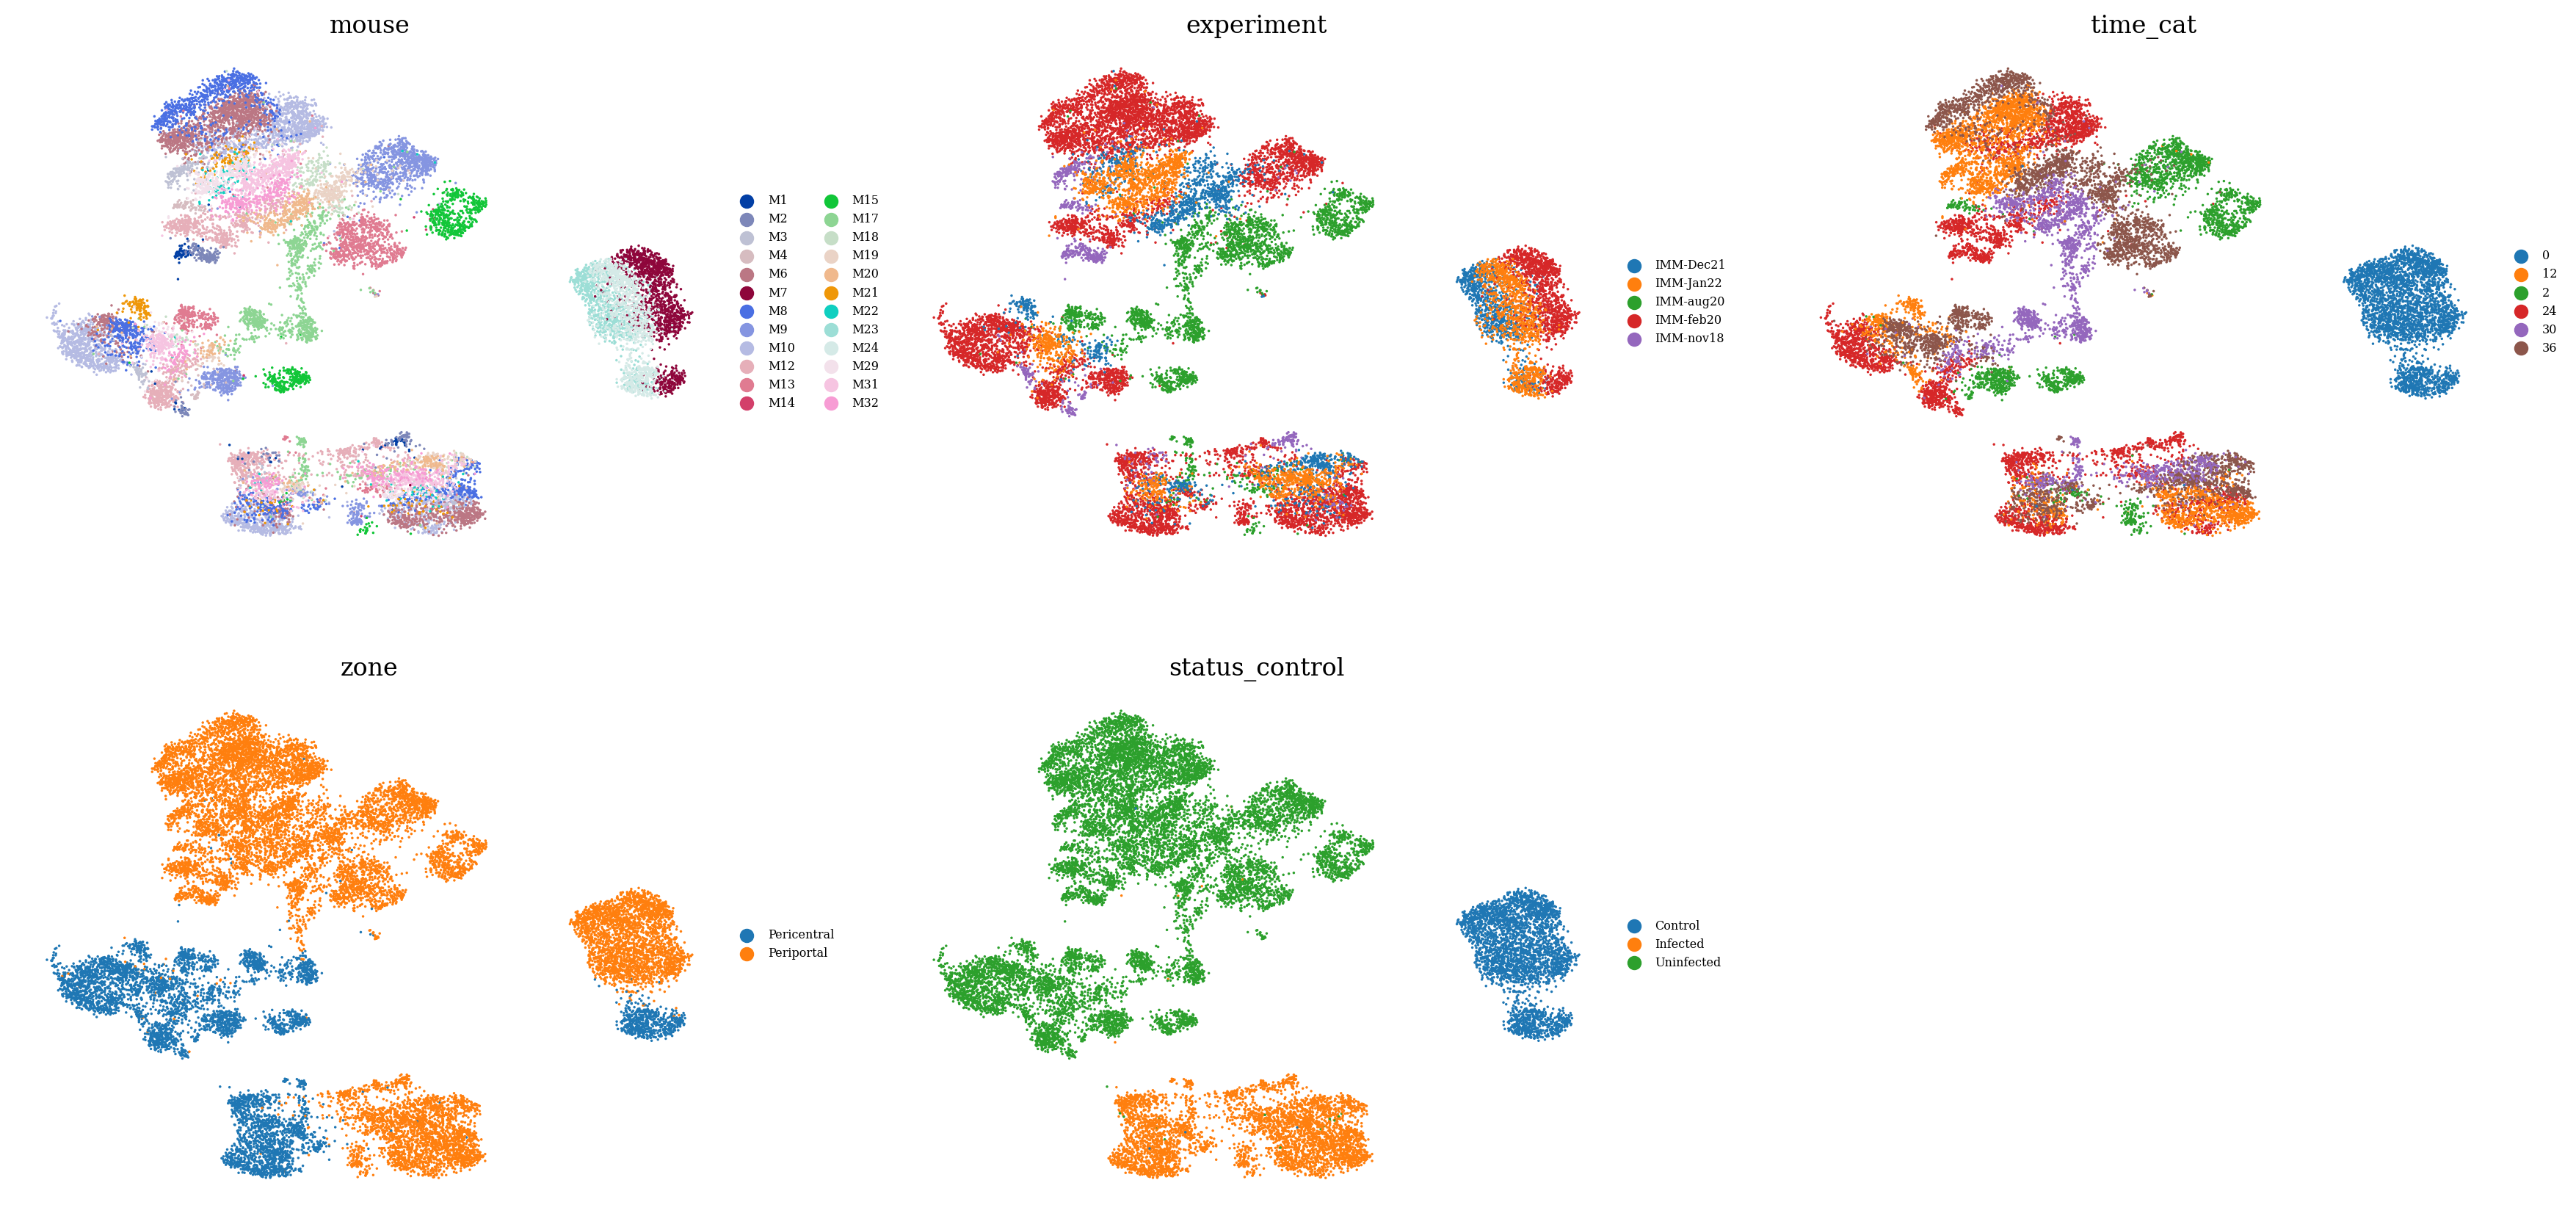

In [18]:
sc.pp.neighbors(latents["latent_after"])
sc.tl.umap(latents["latent_after"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_after"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

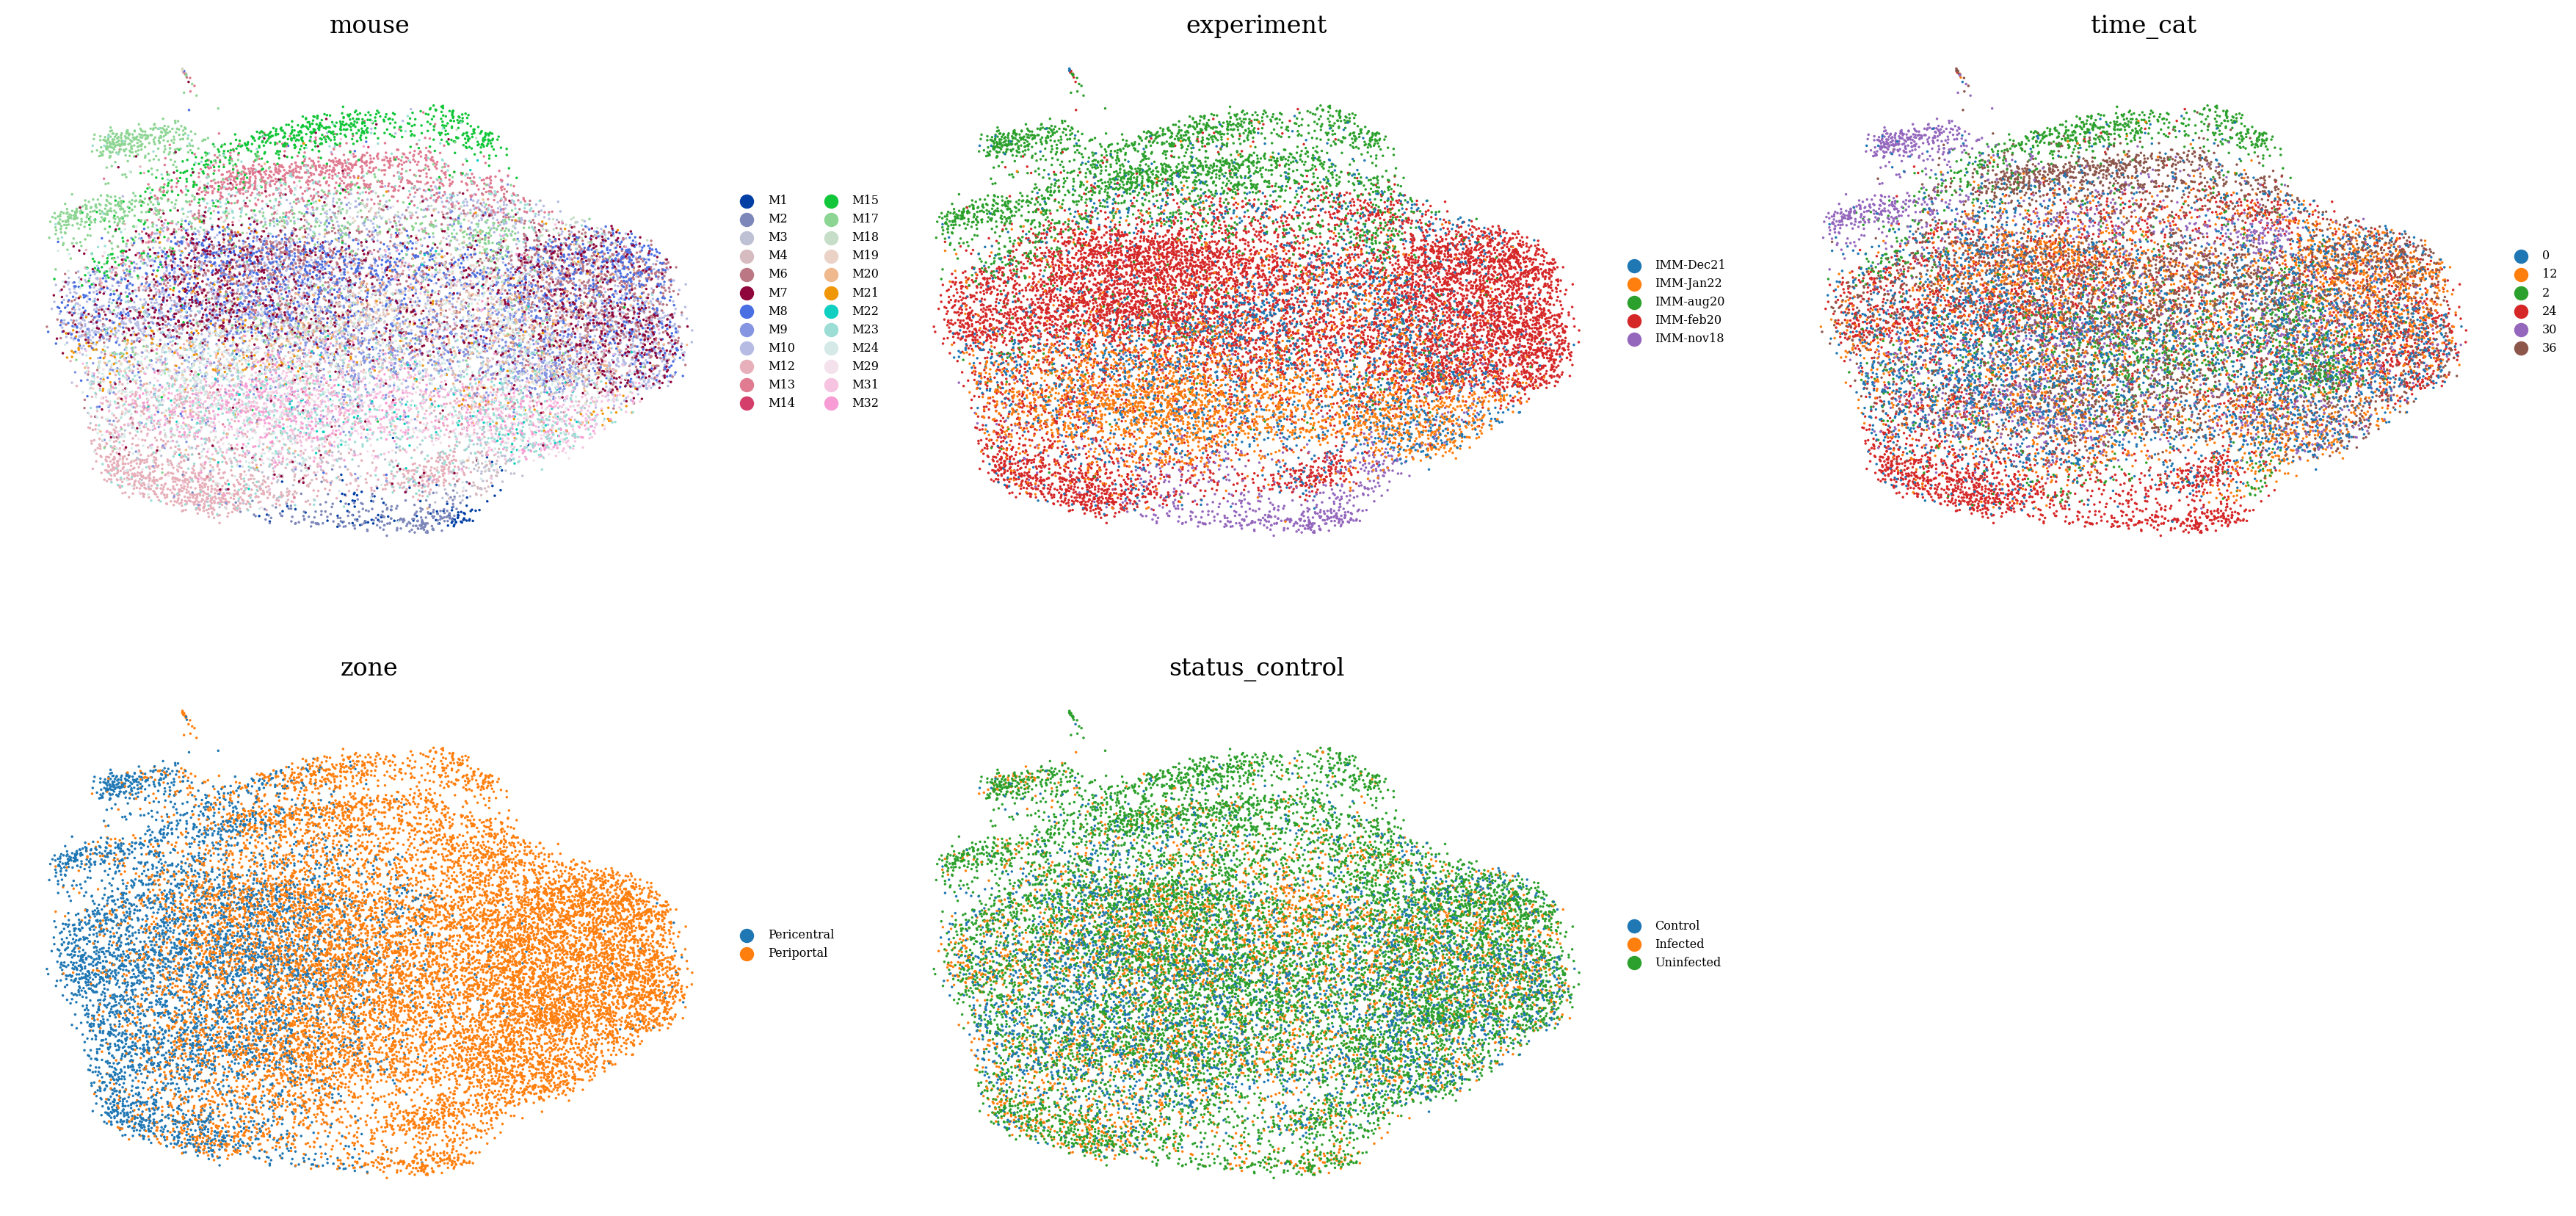

In [19]:
sc.pp.neighbors(latents["latent_basal"])
sc.tl.umap(latents["latent_basal"])

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    sc.pl.umap(
        latents["latent_basal"], 
        color=['mouse', 'experiment', 'time_cat', 'zone', 'status_control'], 
        ncols=3,
        frameon=False,
        legend_fontsize="xx-small"
    )

In [20]:
model.predict()

  0%|          | 0/596 [00:00<?, ?it/s]

  5%|▍         | 29/596 [00:00<00:01, 286.40it/s]

 10%|▉         | 59/596 [00:00<00:01, 291.78it/s]

 15%|█▍        | 89/596 [00:00<00:01, 288.76it/s]

 20%|█▉        | 118/596 [00:00<00:01, 286.18it/s]

 25%|██▍       | 147/596 [00:00<00:01, 284.62it/s]

 30%|██▉       | 176/596 [00:00<00:01, 283.51it/s]

 34%|███▍      | 205/596 [00:00<00:01, 283.08it/s]

 39%|███▉      | 234/596 [00:00<00:01, 281.90it/s]

 44%|████▍     | 263/596 [00:00<00:01, 282.41it/s]

 49%|████▉     | 292/596 [00:01<00:01, 281.78it/s]

 54%|█████▍    | 321/596 [00:01<00:00, 281.72it/s]

 59%|█████▊    | 350/596 [00:01<00:00, 282.21it/s]

 64%|██████▎   | 379/596 [00:01<00:00, 283.00it/s]

 68%|██████▊   | 408/596 [00:01<00:00, 282.90it/s]

 73%|███████▎  | 437/596 [00:01<00:00, 283.13it/s]

 78%|███████▊  | 466/596 [00:01<00:00, 282.97it/s]

 83%|████████▎ | 495/596 [00:01<00:00, 283.36it/s]

 88%|████████▊ | 524/596 [00:01<00:00, 283.16it/s]

 93%|█████████▎| 553/596 [00:01<00:00, 283.28it/s]

 98%|█████████▊| 582/596 [00:02<00:00, 283.30it/s]

100%|██████████| 596/596 [00:02<00:00, 283.37it/s]

In [21]:
pred_adata = adata[model.test_indices]
true = np.array(pred_adata.X)
pred = np.array(pred_adata.obsm["CPA_pred"])

In [22]:
batch_size = 32

r2s = []
start_ind = 0
for end_ind in range(batch_size, len(true), batch_size):
    print(start_ind, end_ind)
    t = true[start_ind:end_ind]
    p = pred[start_ind:end_ind]
    r2 = sklearn.metrics.r2_score(y_true=t.mean(axis=0), y_pred=p.mean(axis=0))
    r2s.append(r2)
    start_ind = end_ind


0

32

32

64

64

96

96

128

128

160

160

192

192

224

224

256

256

288

288

320

320

352

352

384

384

416

416

448

448

480

480

512

512

544

544

576

576

608

608

640

640

672

672

704

704

736

736

768

768

800

800

832

832

864

864

896

896

928

928

960

960

992

992

1024

1024

1056

1056

1088

1088

1120

1120

1152

1152

1184

1184

1216

1216

1248

1248

1280

1280

1312

In [23]:
np.mean(r2s)

0.9311828740438887

In [24]:
dir_path_latent = os.path.join(
    "/home/icb/kemal.inecik/lustre_workspace/tardis_data/_temporary/latent",
    f"afriat_cpa_ood-seed-{ood_seed}_size-{num_ood}.h5ad"
)
adata.write_h5ad(dir_path_latent)